# 0. 인트로
이번 튜토리얼에서는 모델을 직접 구현하기 보다는  
- (1)다양한 Ensemble 계열의 모델들을 시도해보고, 각각의 모델 Hyperparameter 탐색을 수행해 분석해보고자 한다.

- (2)또한 동일한 데이터에 대해 다양한 모델을 활용해 분석하는 것으로 모델간의 비교를 수행하게 되며,  

- (3)서로다른 데이터를 통해 Classification과 Regression을 모두 실험해 본다.

이번 튜토리얼에서 다루는 방법론은 다음과 같다.
1. Boosting-based Ensemble
    - AdaBoost
    - GBM
  
    - Light GBM
    - Catboost
2. Random Forest(RF)

----

사용하는 데이터는 다음과 같다.  
- FashionMNIST  
 : Fashion Mnist는 Pytorch에 내장된 데이터로 28x28의 크기를 가지는 의류 이미지 데이터이다. 0에서 9까지의 총 10개의 label(의류의 종류, target)가 존재하는 범주 분류 데이터이다. 학습데이터로 60000개, 테스트데이터로 10000개가 준비되어 있다.   
 그러나 학습에 너무 많은 시간이 소요되어 학습에 1000개, 테스트에 200개의 이미지를 사용하였다.  



- Wine
 : UCI Machine Learning Repository에서 받을 수 있는 동일한 지역의 서로다른 3개의 와이너리로 부터 수집한 Wine dataset으로 각 와이너리 정보에 따라 3 class를 가진다. 총 13개의 변수가 포함되어 분류 혹은 군집화 과업에 사용될 수 있다.   
 본 실습에서는 Classification 성능 실험에 사용한다. 
 http://www.ics.uci.edu/~mlearn/MLSummary.html or ftp://ftp.ics.uci.edu/pub/machine-learning-databases/wine/


- Cereals
 : DASL에서 받을 수 있는 판매되고 있는 시리얼 제품에 대한 데이터, 각종 영양 정보와 제조사 정보를 포함하고 있으며 소비자 만족도 점수를 포함하고 있다. 본 실습에서는 본 데이터를 활용하여 Regression(예측) task 실험을 수행한다.  
 http://lib.stat.cmu.edu/DASL/Stories/HealthyBreakfast.html

<p align="center">   <image src="./images/2022-12-01-21-19-48.png" width="60%"/>   </p>

---

아래 부터의 실습은 위 표에서 정리한 데이터셋 별로 진행되는 점 참고 바란다.

# 1. FashionMNIST
- Boosting-based Ensemble
  - AdaBoost
  - GBM

  - Light GBM
  - Catboost
  
각 모델 구현과 비교 및 하이퍼 파라미터 탐색 
## 1.0 라이브러리 불러오기

In [ ]:
# 실습용 데이터 관련 패키지
import torch
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

# 데이터 처리
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 모델 생성, 학습, 평가
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from lightgbm import LGBMClassifier # 패키지 설치: !pip install lightgbm
from catboost import CatBoostClassifier # 패키지 설치: !pip install catboost
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import torch
from sklearn.metrics import accuracy_score, recall_score, precision_score, mean_squared_error, mean_absolute_error, r2_score
device = torch.cuda.is_available() 
# Catboost와 Lightgbm은 gpu 사용이 가능


# 시각화 & 편의용
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams['axes.unicode_minus'] = False

# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')

## 1.1 data
 데이터는 28x28 행렬형태에 각각의 자리에 흑백의 명도가 0부터 255까지의 숫자로 표시되어 있다. 이후의 분석을 위해 평균과 표준편차를 0과 1로 scaling한 후 seed=0으로 고정한 무작위 sample 함수를 이용해 1000/200개의 학습, 테스트 데이터로 분리한다.  

 
1.1.1 FashionMNIST 다운로드

In [ ]:
# Fashion MNIST 데이터를 저장할 directory
download_root = './'

# 데이터 scaling을 위한 요소
fasion_mnist_transform = transforms.Compose([
    transforms.ToTensor(), # 데이터 형태를 Pytorch에 적합한 형태로 바꾸어 줌
    transforms.Normalize((0.0,), (1.0,)) # feature들의 평균과 표준편차를 0과 1로 scaling 해줌
])

#FashionMNIST 훈련 데이터셋 다운로드
dataset = FashionMNIST(download_root, transform=fasion_mnist_transform, train=True, download=True)

# 테스트 데이터셋 다운로드
test_dataset = FashionMNIST(download_root, transform=fasion_mnist_transform, train=False, download=True)

1.1.2 사용할 데이터 분리

In [ ]:
import random
random.seed(0)
sample_idx_train = random.sample(range(60000),1000)
sample_idx_test = random.sample(range(10000),200)

1.1.3 이미지 데이터 전처리(reshape & 일부만 선택)

In [ ]:
# seeds = [0 for i in range(10)]
seeds = 0
output = pd.DataFrame([]) # 학습 결과를 저장할 DataFrame

X_train_sampled=dataset.data.numpy().reshape(60000,784)[sample_idx_train]
y_train=dataset.targets.numpy()[sample_idx_train]
X_test_sampled=test_dataset.data.numpy().reshape(10000,784)[sample_idx_test]
y_test=test_dataset.targets.numpy()[sample_idx_test]

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

# 1.2 Boosting-based Ensemble 모델 탐색
## 1.2.1
탐색하고자 하는 하이퍼파라미터 설정  

<p align="center">   <image src="./images/2022-12-01-20-33-52.png" width="60%"/>   </p>

Gridsearchcv 함수를 이용하여 4가지 부스팅 모델에 대한 하이퍼파라미터를 탐색하고 결과 시각화

In [ ]:
# Gridsearchcv를 수행 할 하이퍼파라미터를 설정
model_params = {"GBM": {'model': GradientBoostingClassifier(random_state=0), # 그레디언트 부스팅
                        'params': { 'learning_rate': [0.2*(i+1) for i in range(3)], # 학습률, Shrinkage율
                                    'n_estimators': [50*(i+1) for i in range(3)] , 
                                    'subsample':[0.5,0.75,1.0],
                                    'max_depth':[i for i in range(1,11,2)]
                                  }},

                "AdaBoost": {'model': AdaBoostClassifier(random_state=0),# 에이다 부스팅
                        'params': {'base_estimator':  [DecisionTreeClassifier(max_depth=i) for i in range(1,11,2)], # 약분류기 (주로 의사결정나무를 사용)
                                   'n_estimators':[50*(i+1) for i in range(3)], 
                                   'learning_rate':[0.2*(i+1) for i in range(3)]}},
                
                'Light GBM' : {'model' : LGBMClassifier(random_state=0, silent=True, device='gpu') if device == True else LGBMClassifier(random_state=0, silent=True),
                          'params' : {'max_depth':[i for i in range(1,11,2)],
                                      'n_estimators':[50*(i+1) for i in range(3)],
                                      'learning_rate': [0.2*(i+1) for i in range(3)]
                                     }},
                
                'Catboost' : {'model' : CatBoostClassifier(random_seed=0, silent=True, task_type = 'GPU', thread_count = 5 , gpu_ram_part = .5) if device == True else CatBoostClassifier(random_seed=0, silent=True), 
                              'params' : {'max_depth':[i for i in range(1,11,2)] ,
                                          'n_estimators':[50*(i+1) for i in range(3)],
                                          'learning_rate': [0.2*(i+1) for i in range(3)]
                                     }}
                                    }

scoring 기준은 accuracy, Fold 수는 3가 되도록 GridSearchCV() 수행하여 그 결과를 데이터프레임으로 저장

In [ ]:
pbar = tqdm(total=len(model_params)) # 진행상황을 보여주는 tqdm

# 4가지 모델에 대한 학습 시작 # 
for model_name, v in model_params.items():

    pbar.set_description(desc=f"{model_name}") # 현재 학습되고 있는 모델 이름을 출력
        
    model, params = v['model'], v['params']
    gcv = GridSearchCV(estimator=model, param_grid=params, n_jobs=2 if model_name == 'Catboost' else 5, cv=3, scoring='accuracy')
    gcv.fit(X_train_sampled, y_train)
        
    result = pd.DataFrame.from_dict(gcv.cv_results_) # cv_results에 각 fold별 예측 성능 기록
    result['test_accuracy_with_best_hyp'] = accuracy_score(y_pred = gcv.predict(X_test_sampled) , y_true = y_test) #gcv.predict() 최적 하이퍼파라미터 모델의 예측 결과 산출
    result['model_name'] = model_name
    result['seed'] = 0
    output = pd.concat([output,result])
    pbar.update(1)

output.reset_index(drop=True)       
output.to_csv('./classification_result.csv')

위 반복문을 통해 앞서 정의한 하이퍼파라미터 후보들이 각각의 모델에 모두 학습이 수행되고, 그 결과가 csv 파일로 저장된다.

In [ ]:
def show_result(model_name):
    '''
    GridSearchCV를 통해 학습된 모델의 결과를 시각화
    '''
    for_plot_values = output.loc[ output['model_name'] == model_name,:] # 탐색하고자하는 모델의 결과만 추출

    fig , axs = plt.subplots(nrows=model_params[model_name]['params'].keys().__len__(), ncols=1, figsize=(50,80)) # plot configure
    fig.suptitle(f'{model_name} performance for each hyperparameter',fontsize=50) # 전체 Plot 제목

    for ind , param_key in enumerate(model_params[model_name]['params'].keys()):
        
        param_for_plot = for_plot_values.groupby([f'param_{param_key}'])['mean_test_score'].mean() # 조절 하이퍼파라미터 이외에 대해서는 평균 성능 (개략적)
        
        axs[ind].bar(height = param_for_plot.values,x = [i for i in range(param_for_plot.values.shape[0])]) # bar plot 
        axs[ind].tick_params(axis='both',labelsize=20)
        
        axs[ind].set_xticks([i for i in range(param_for_plot.values.shape[0])]) # x ticks 설정
        axs[ind].set_xticklabels(param_for_plot.index.to_list()) # xticks 이름 설정

        axs[ind].set_title(f'{param_key}',fontsize=50)

앞서 생성한 결과 dataframe에서 함수에 입력하는 모델의 결과를 시각화 한다.

In [ ]:
#저장된 결과 가져오기
output = pd.read_csv('./classification_result.csv',index_col=0)

In [ ]:
show_result('AdaBoost')

<p align="center">   <image src="./images/2022-12-01-22-46-52.png"/>   </p>

base_estimator 
: 4, 5 근처에서 높은 성능을 보인다.
n_estimator
: 100 근처에서 높은 성능을 보인다.

learning
: 0.4 근처에서 가장 뛰어나다


In [ ]:
show_result('GBM')

<p align="center">   <image src="./images/2022-12-01-22-43-28.png"/>   </p>

learning rate
: 0.2로 작아질수록 높은 성능을 보인다.

n_estimator 
: 100에서 가장 높은 성능을 보인다.

subsample
: 1로 커질수록 높은 성능을 보인다.

max_dept
: 5근처에서 가장 높은 성능을 보인다.


In [ ]:
show_result('Light GBM')

<p align="center">   <image src="./images/2022-12-01-22-47-15.png"/>   </p>

max_dept
: 3 근처에서 가장 뛰어나다
n_estimator
: 50에서 뛰어나며, 거의 비슷한 수준을 보인다.

learning
: 0.2근처에서 뛰어나다.


In [ ]:
show_result('Catboost')

<p align="center">   <image src="./images/2022-12-01-22-47-27.png"/>   </p>

max_dept 
: 3 근처에서 가장 뛰어나다 
n_estimator 
:150 근처에서 뛰어나며, 거의 비슷한 수준을 보인다.
learning :0.2 근처에서 뛰어나고, 다른 모델에 비해 둔감하다.


In [ ]:
fig , axs = plt.subplots(nrows=len(model_params), ncols=1, figsize=(50,80))
fig.suptitle('Model performance for each hyperparameter',fontsize=50)
for ind, model_name in enumerate(model_params):
    for_plot_values = output.loc[ output['model_name'] == model_name,:] # model_name 데이터만 인덱싱
    axs[ind].bar(height = for_plot_values['mean_test_score'] , x = [i for i in range(for_plot_values.shape[0])]) # 모든 하이퍼파라미터 조합에 따른 예측 성능 시각화
    axs[ind].tick_params(axis='y',labelsize=50)
    axs[ind].set_title(f'{model_name}',fontsize=50)

<p align="center">   <image src="./images/2022-12-01-22-47-46.png"/>   </p>

전체적 하이퍼파라미터에 따른 모델의 성능은 위 그림과 같다. GBM모델은 하이퍼 파라미터에 대해 매우 민감하게 성능이 변하는 반면 Light GBM모델은 비교적 민감도가 낮아 비슷한 성능을 유지한다.

In [ ]:
## 최적의 하이퍼파라미터 모델의 K-fold 예측 성능 시각화

plt.figure(figsize=(10,10))
output.groupby(['model_name'])['mean_test_score'].max().plot.bar()
plt.title('Predictive performance of models with optimal hyperparameters',fontsize=20)
plt.yticks(fontsize=20)
plt.show()

<p align="center">   <image src="./images/2022-12-01-22-48-18.png"/>   </p>

이때, 최고의 성능을 보이는 hyperparameter 조합에서 산출하는 분류 Accuracy는 다음과 같다.
- Adaboost: 0.68
- GBM: 0.78
- Light GBM: 0.78
- Catboost: 0.62

## 1.2.2 앞선 결과를 기준으로 추가적인 세밀탐색 수행
 위 1번 문제에서 각각의 모델 hyperparameter에 대해 어떤 성능을 보이는 지를 해석한 것을 토대로 가장 뛰어난 성능을 보이는 hyperparameter 값 근처를 더 면밀하게 탐색하자. 해당 지점은 위 문제에서 언급한 최고성능을 보이는 위치이고 타른 모델과의 민감도를 비교하여 그 범위를 조정하였다.

 <p align="center">   <image src="./images/2022-12-01-20-40-19.png" width="60%"/>   </p>

In [ ]:
# 추가 하이퍼파라미터 탐색 ( 촘촘하게 )
model_params = {"GBM": {'model': GradientBoostingClassifier(random_state=0),
                        'params': { 'learning_rate': list(np.arange(0.05,0.20,0.01)),# 0.2 근처 혹은 작을수록 좋은 성능을 보였음
                                    'n_estimators': [50] , # 너무 많은 모델 개수를 필요로 하지 않아 보였음 (50에서 가장 Best)
                                    'subsample':[1.0], # 1에 가까울수록 좋은 성능을 보였음
                                    'max_depth':[7,8,9] # 7과 9 사이에서 더 조밀하게 탐색
                                  }},

                "AdaBoost": {'model': AdaBoostClassifier(random_state=0),
                        'params': {'base_estimator':  [DecisionTreeClassifier(max_depth=i) for i in [7,8,9]], # 7과 9 사이에서 더 조밀하게 탐색
                                   'n_estimators':[50], # 너무 많은 모델 개수를 필요로 하지 않아 보였음 (50에서 가장 Best)
                                   'learning_rate':list(np.arange(0.05,0.20,0.01))}},
                
                'Light GBM' : {'model' : LGBMClassifier(random_state=0, silent=True, device='gpu') if device == True else LGBMClassifier(random_state=0, silent=True),
                          'params' : {'max_depth':[1,2,3], # 작을수록 좋은 성능을 보였음
                                      'n_estimators':[100], # 성능에 큰 영향을 미치는 것으로 판단되지 않음
                                      'learning_rate': list(np.arange(0.05,0.20,0.01))}},# 작을수록 좋은 성능을 보였음
                
                'Catboost' : {'model' : CatBoostClassifier(random_seed=0, silent=True, task_type = 'GPU', thread_count = 5 , gpu_ram_part = .5) if device == True else CatBoostClassifier(random_seed=0, silent=True), 
                              'params' : {'max_depth':[8,9,10] , # 9 근처에서 좋은 성능을 보였으니, 11 근방 탐색
                                          'n_estimators':[150], # 성능에 큰 영향을 끼치지 않을 것으로 판단됨.
                                          'learning_rate': list(np.arange(0.05,0.20,0.05)) # 다른 모델보단 성능에 둔감하게 영향을 끼침. rough하게 탐색
                                     }}}

# Train
seeds = [0]
pbar = tqdm(total=len(model_params)*len(seeds))
output = pd.DataFrame([])

for model_name, v in model_params.items():

    pbar.set_description(desc=f"{model_name}")
    model, params = v['model'], v['params']
    gcv = GridSearchCV(estimator=model, param_grid=params, n_jobs=2 if model_name == 'Catboost' else 5, cv=5, scoring='accuracy')
    gcv.fit(X_train_sampled, y_train)
    
    result = pd.DataFrame.from_dict(gcv.cv_results_)
    result['test_accuracy_with_best_hyp'] = accuracy_score(y_pred = gcv.predict(X_test_sampled) , y_true = y_test)
    result['model_name'] = model_name
    result['seed'] = seeds[0]
    output = pd.concat([output,result])
    pbar.update(1)

output.reset_index(drop=True)       
output.to_csv('./data/classification_result2.csv')

변경된 hyperparameter를 사용하여 앞에서 수행한 것과 같이 scoring 기준은 accuracy, Fold 수는 3가 되도록 GridSearchCV() 수행한다. 이때 최종적으로 선택한 최적 조합에서의 분류 accuracy는 각각 다음과 같다.

In [ ]:
## 최적의 하이퍼파라미터 예측 모델의 test 데이터 예측 성능 시각화

output = pd.read_csv('./data/classification_result.csv',index_col=0)
output.reset_index(drop=True,inplace=True) # index 초기화 
plt.figure(figsize=(10,10))

idx = output.groupby(['model_name'])['mean_test_score'].idxmax() # 각 모델별 검증용 accuracy를 기준하여, Best 성능을 기록한 경우 추출
output.loc[idx,['model_name','test_accuracy_with_best_hyp']].set_index('model_name').plot.bar(legend=False)
plt.title('Predictive performance of models with optimal hyperparameters',fontsize=20)
plt.yticks(fontsize=20)
plt.show()

<p align="center">   <image src="./images/2022-12-01-22-48-43.png"/>   </p>

- Adaboost: 0.74
- GBM: 0.68
- Light GBM: 0.66
- Catboost: 0.78

AdaBoost와 Catboost의경우 성능이 향상되었으며, Light GBM의 경우는 동일한 성능을 보인다. 그러나 GBM은 오히려 떨어진 성능을 보이고 있다. 성능이 향상되거나 동일한 것은 더 면밀히 hyperparameter를 탐색하였을 때, 자연스러운 일이나 오히려 성능이 떨어지는 것은 의아한 일이다. 이는 우선 앞서 분석하였듯이 GBM이 가장 hyperparameter에 민감하게 성능이 변하는 모델이었기 때문일 것이다. 특히 이번 분석에서 가장 뛰어난 모델의 hyperparameter를 선택하는 방법이 각각의 fold에서 얻은 3개의 accuracy 값의 평균이 가장 높은 순으로 정렬한 것인데, 여기서 오류가 발생했을 것으로 보인다. 물론 각각의 성능이 뛰어난 개별 모델들을 합하면 더 뛰어난 Ensemble 결과를 얻을 수 있으나, 모델 사이에 상호작용, 궁합 등에 의해 더 낮은 개별 성능을 가진 모델이 앙상블을 이루었을 때 더 은 성능을 보일 수 있기 때문이다.


이번 경우 AdaBoost, Catboost, Light GBM은 새로 만든 모델에서 바로 선택하여 사용하면 되며, GBM은 이전 학습의 결과를 기록한 데이터 프레임에서 해당 hyperparameter 조합을 읽어와서 사용하면 모든 모델에서 최적의 조합을 얻을 수 있다. 즉 최종적으로 GBM, Light GBM이 0.78의 accuracy로 최고성능을 보이는데, 앞서 확인했듯이 민감도가 더 낮은 Light GBM이 이번 데이터에 대해 가장 적절한 모델로 보인다.


# 2. Wine
- Random Forest classifier 구현 및 하이퍼 파라미터 탐색
- Boosting 계열 모델과의 비교

## 2.0 라이브러리 불러오기

In [ ]:
from IPython.display import display, HTML
import warnings
warnings.filterwarnings(action='ignore')

# 데이터 전처리
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 기계학습 모델 및 평가
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm
from sklearn.model_selection import KFold

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import ListedColormap
matplotlib.rcParams['axes.unicode_minus'] = False

# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')

## 2.1 data

In [ ]:
# 데이터 로드, 데이터 자체에 대한 EDA를 우선 적으로 수행
wine =pd.read_excel('Wine.xls')
# cereals =pd.read_excel('Cereals.xls')

In [ ]:
print(f'관측치 수 : {wine.shape[0]} \n변수 수 : {wine.shape[1]}')

관측치 수 : 178 
변수 수 : 14


In [ ]:
target = [col for col in wine.columns if wine[col].dtype == "object"]
print(target)

feature = list(set(wine.columns) - set(target))
print(feature)

['Type']
['Malic_Acid', 'Total_Phenols', 'Hue', 'Color_Intensity', 'Ash_Alcalinity', 'Magnesium', 'Proline', 'Flavanoids', 'Nonflavanoid_Phenols', 'Ash', 'OD280_OD315', 'Alcohol', 'Proanthocyanins']


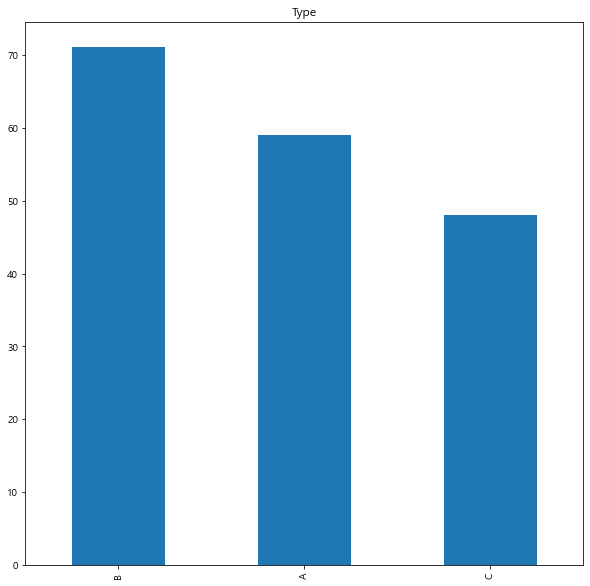

In [ ]:
wine['Type'].value_counts().plot(kind='bar', figsize = (5,5))
plt.title('Type')
plt.show()

범주간의 불균형이 크게 발생하지 않으므로 classification task를 수행하는데에 문제가 없어 보인다.

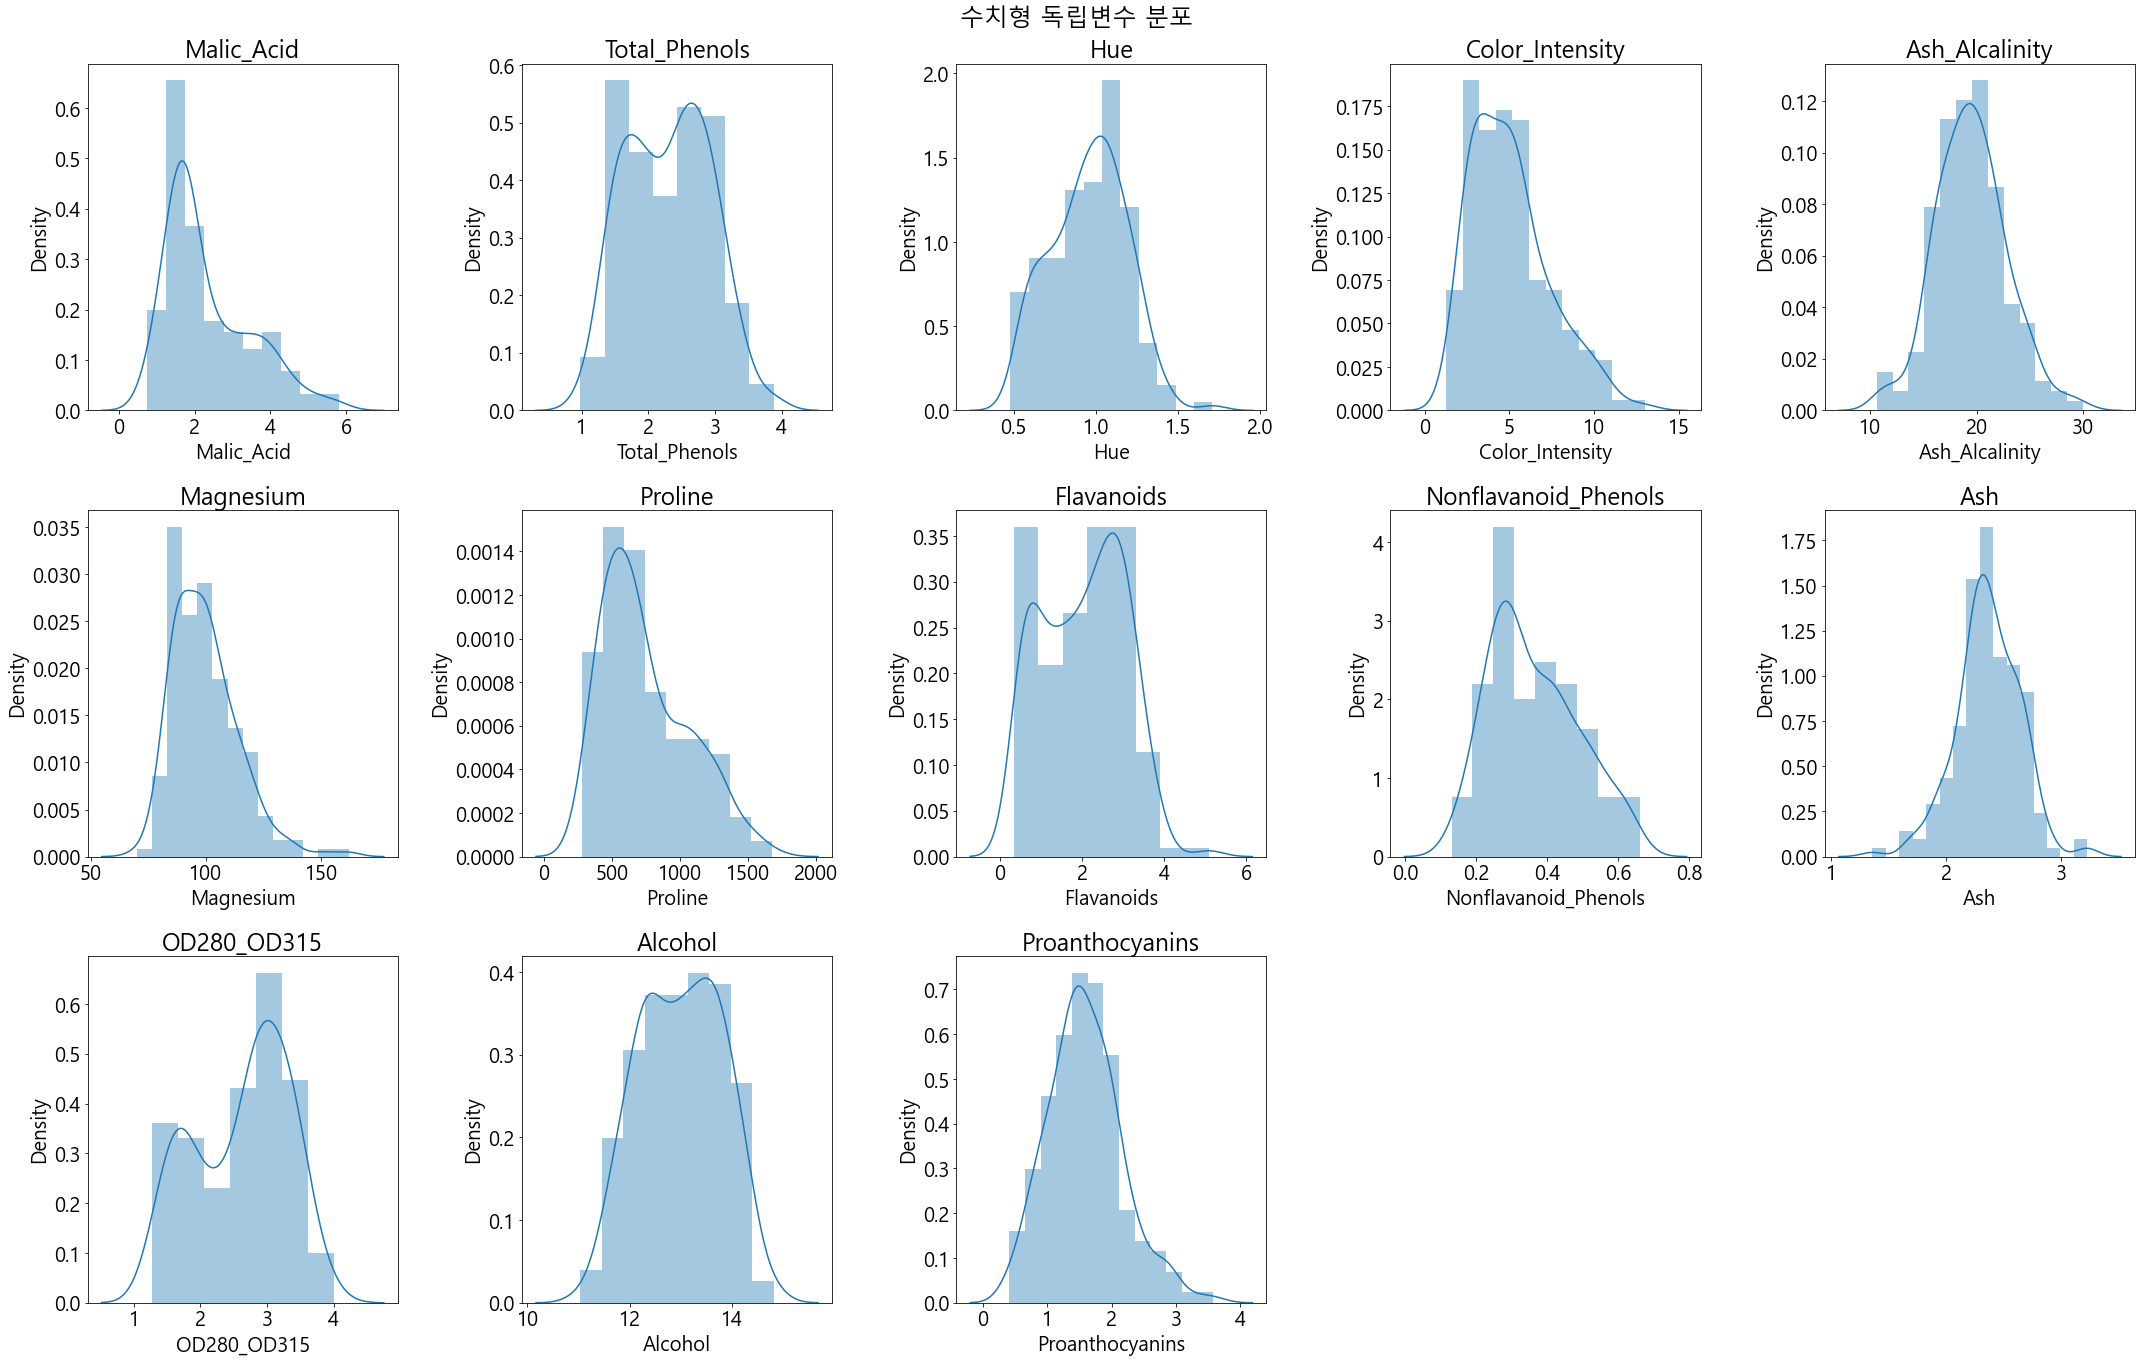

In [ ]:
fig = plt.figure(figsize=(30,25))
plt.rc('font', size=20)
fig.suptitle('수치형 독립변수 분포')

for i in range(len(feature)):
    ax = fig.add_subplot(4,5,i+1)
    ax = sns.distplot(wine[feature[i]])
    plt.title(feature[i])
fig.tight_layout()
plt.show()

각각의 변수 분포도 특이사항이 발견되지 않는다

<AxesSubplot:>

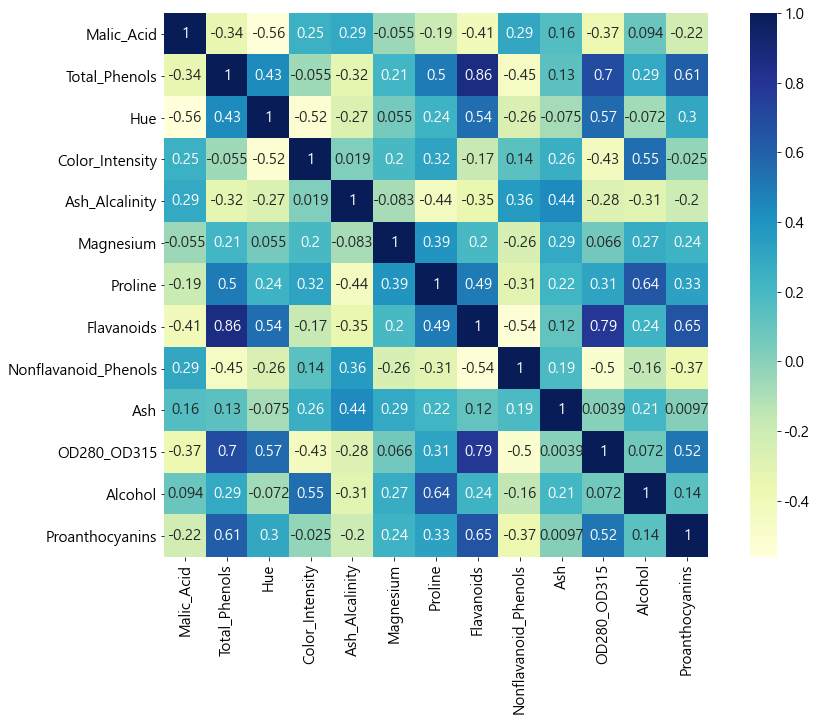

In [ ]:
#상관관계분석 피어슨 이용
plt.figure(figsize=(15,10))
plt.rc('font', size=15)
sns.heatmap(wine[feature].corr(),annot=True,square = True, annot_kws={'size' : 15},cmap='YlGnBu')


 변수간의 상관관계는 위 그림처럼 몇몇 높은 상관관계를 보이는 경우가 있으나 decision tree를 기본으로하는 랜덤 포레스트모델의 특성상 크게 상관이 없으며 이후 부스팅 분석을 수행할 때만 정규화를 수행하도록한다.

In [ ]:
X = wine.drop('Type', axis=1)
y = pd.DataFrame(wine['Type'])
X

,Alcohol,Malic_Acid,Ash,Ash_Alcalinity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280_OD315,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


In [ ]:
y.value_counts()

Type
B       71
A       59
C       48
dtype: int64

이제 앞서 파악한 y의 Type 분포를 만족하도록 stratify=y 조건을 사용해 data를 training set, testing set으로 나눈다. (7:3의 비율) 

In [ ]:
# Train set/ Test set 나누기 
''' stratify= y: y의 비율유지하며 데이터 나누기를 수행한다'''
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3,random_state=2021)


print(f'Train set dimension is {X_train.shape}')
print(f'Test set dimension is {X_test.shape}')

Train set dimension is (124, 13)
Test set dimension is (54, 13)


## 2.2 RandomForest Classifier modeling

우선 기본적인 랜덤 포레스트의 성능을 알아보기 위해 앙상블을 수행하는 tree의 수를 10개로 고정하고 다른 하이퍼파라미터의 조작없이 모델을 학습시키면 다음과 같은 성능을 보인다.

In [ ]:
rfc = RandomForestClassifier(n_estimators=10,random_state=2021)
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=2021)

In [ ]:
# Train set에 대한 성능
y_pred = rfc.predict(X_train)
acc = accuracy_score(y_true = y_train, y_pred =y_pred)
print("Train set에 대한 성능")  
print(f"정확도:{acc:0.4f}")  

# Test set에 대한 성능
y_pred = rfc.predict(X_test)
acc = accuracy_score(y_true = y_test, y_pred =y_pred)
print("\n")  
print("Test set에 대한 성능")  
print(f"정확도:{acc:0.4f}")  

Train set에 대한 성능
정확도:1.0000


Test set에 대한 성능
정확도:0.9630


 위와 같이 이미 거의 완벽하게 분류를 수행하고 있다. 그러나 이는 이번 training, testing dataset에 대한 것으로 완전히 새로운 데이터가 입력되었을 때는 완벽하게 분류를 할지는 알 수가 없다. 또한 각각의 하이퍼파라미터의 변화에 따른 성능 변화를 살펴보기 위해 몇 가지 조작을 수행해보도록 하자.

## 2.3 단일 하이퍼 파라미터에 대한 Grid search
- n_estimator
- the max depth of tree
- the max leaf node of tree

### 2.3.1 n_estimator


 K-fold cross validation을 이용해 하이퍼파라미터 변화에 따른 예측성능의 변화를 살펴보자. GridSearchCV를 이용하면 다양한 파라미터를 동시에 변화시켜가며 성능을 탐색이 가능하나, 각각의 하이퍼파라미터의 성능에의 영향을 살펴보기 위해 우선 매번 하나의 하이퍼파라미터만을 변화시켜보자. 또한 여기서 얻은 하이퍼 파라미터에 따른 성능 변화를 통해 최종적으로 한 번에 모든 하이퍼파라미터를 변화시킬 때, 탐색할 범위를 정할 수 있을 것이다.

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:38<00:00,  1.31it/s]


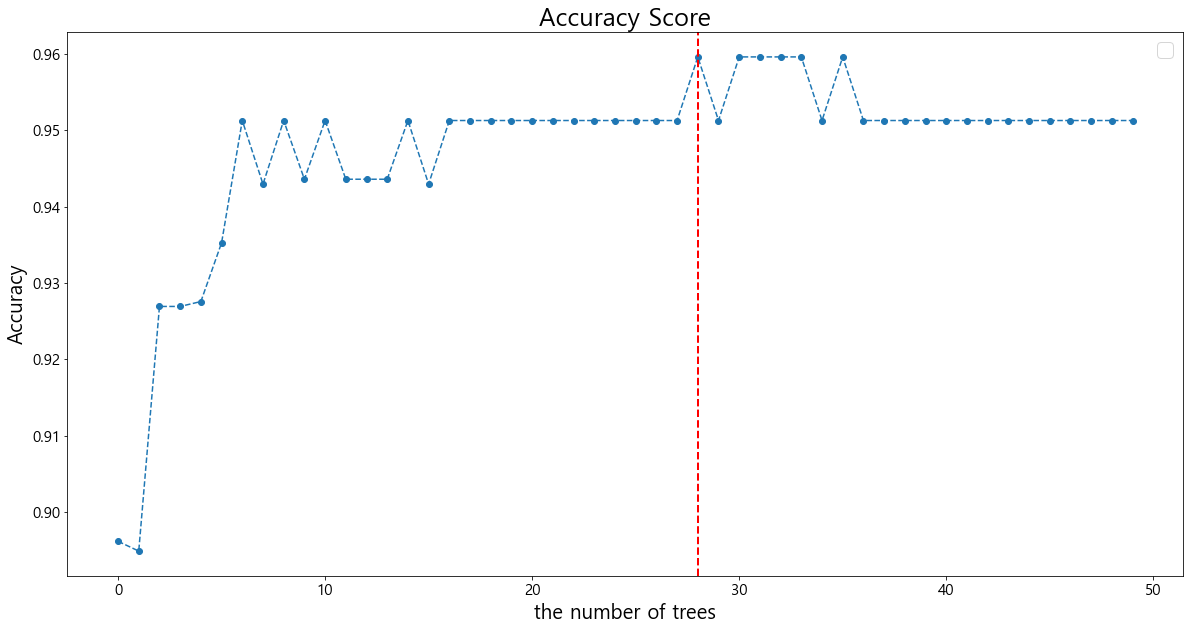

In [ ]:
cv_scores = []
estimator_list =[i for i in range(0,50,1)]
for i in tqdm(range(0,50,1)):
    rfc = RandomForestClassifier(n_estimators=i+1,
                                 n_jobs=-1,
                                 random_state=2021)
    score = cross_val_score(rfc, X_train, y_train, cv=10, scoring = 'accuracy').mean()
    cv_scores.append(score)

best_e = [estimator_list[i] for i in range(len(cv_scores)) if cv_scores[i] == np.max(cv_scores)]
plt.figure(figsize=(20,10))
plt.legend(["Cross validation scores"], fontsize=20)
plt.plot(estimator_list,cv_scores, marker='o', linestyle='dashed')
plt.xlabel("the number of trees", fontsize=20 )
plt.ylabel("Accuracy", fontsize=20)
plt.title("Accuracy Score", fontsize=25)
plt.axvline(best_e[0], color='r', linestyle='--', linewidth=2)
plt.show()

 사용할 나무의 수를 1개부터 50개까지 모두 탐색한 결과를 보여주는 그래프이다. 붉은 점선은 가장 먼저 최고의 예측 성능을 보여준 지점을 가르킨다. 사용하는 나무의 수가 늘어날수록 예측의 성능이 증가하다가 일정 수준이상으로 증가하면 성능이 더 이상 증가하지 않는다. 특히 특정 지점 이후에는 오히려 성능이 감소하기까지 한다. 또한 나무의 수가 증가할수록 모델이 소요하는 시간이 길어진다는 것을 생각하면 일정 수준 이상으론 증가시키면 안 될 것이다.

In [ ]:
print(f"최적의 tree개수:{(cv_scores.index(max(cv_scores)))+1}")
print("\n")  
print("Train set에 대한 성능 (10 fold cross validation)")  
print(f"정확도:{max(cv_scores):0.4f}")  

최적의 tree개수:29


Train set에 대한 성능 (10 fold cross validation)
정확도:0.9596


 결과적으로 이번 training dataset에서는 29개의 tree수가 최적의 지점이며 이때 예측의 성능은 위에 나타난대로 training, testing 모두에 대해 0.95의 성능을 보인다.

In [ ]:
rfc = RandomForestClassifier(n_estimators=29, n_jobs=-1, random_state=2021)
rfc.fit(X_train, y_train)

# Train set에 대한 성능
y_pred = rfc.predict(X_train)
acc = accuracy_score(y_true = y_train, y_pred =y_pred)
print("Train set에 대한 성능")  
print(f"정확도:{acc:0.4f}")  

# Test set에 대한 성능
y_pred = rfc.predict(X_test)
acc = accuracy_score(y_true = y_test, y_pred =y_pred)
print("\n")  
print("Test set에 대한 성능")  
print(f"정확도:{acc:0.4f}")  

Train set에 대한 성능
정확도:1.0000


Test set에 대한 성능
정확도:1.0000


### 2.3.2 the max depth of tree


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:30<00:00,  1.65it/s]


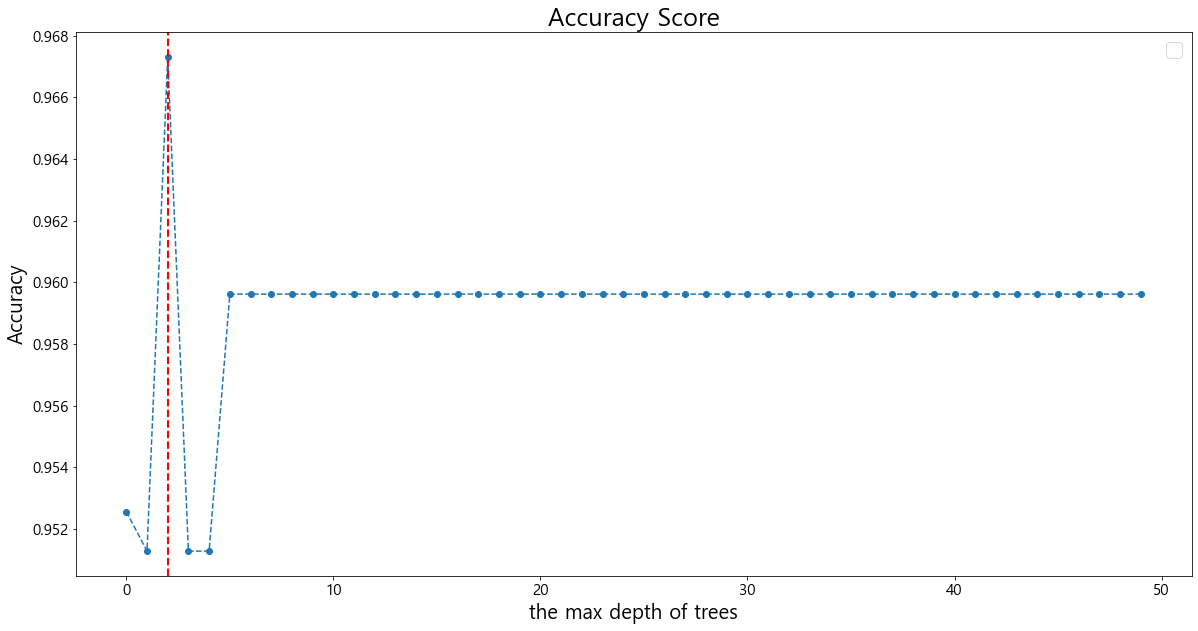

In [ ]:
cv_scores = []
estimator_list =[i for i in range(0,50,1)]
for i in tqdm(range(0,50,1)):
    rfc = RandomForestClassifier(n_estimators=29,
                                 max_depth=i+1,
                                 n_jobs=-1,
                                 random_state=2021)
    score = cross_val_score(rfc, X_train, y_train, cv=10, scoring = 'accuracy').mean()
    cv_scores.append(score)

best_e = [estimator_list[i] for i in range(len(cv_scores)) if cv_scores[i] == np.max(cv_scores)]
plt.figure(figsize=(20,10))
plt.legend(["Cross validation scores"], fontsize=20)
plt.plot(estimator_list,cv_scores, marker='o', linestyle='dashed')
plt.xlabel("the max depth of trees", fontsize=20 )
plt.ylabel("Accuracy", fontsize=20)
plt.title("Accuracy Score", fontsize=25)
plt.axvline(best_e[0], color='r', linestyle='--', linewidth=2)
plt.show()

In [ ]:
print(f"최적의 max_depth:{(cv_scores.index(max(cv_scores)))+1}")
print("\n")  
print("Train set에 대한 성능 (10 fold cross validation)")  
print(f"정확도:{max(cv_scores):0.4f}")  

최적의 max_depth:3


Train set에 대한 성능 (10 fold cross validation)
정확도:0.9673


In [ ]:
rfc = RandomForestClassifier(n_estimators=29,max_depth=3, n_jobs=-1, random_state=2021)
rfc.fit(X_train, y_train)

# Train set에 대한 성능
y_pred = rfc.predict(X_train)
acc = accuracy_score(y_true = y_train, y_pred =y_pred)
print("Train set에 대한 성능")  
print(f"정확도:{acc:0.4f}")  

# Test set에 대한 성능
y_pred = rfc.predict(X_test)
acc = accuracy_score(y_true = y_test, y_pred =y_pred)
print("\n")  
print("Test set에 대한 성능")  
print(f"정확도:{acc:0.4f}")  

Train set에 대한 성능
정확도:0.9919


Test set에 대한 성능
정확도:1.0000


 이번에 확인할 하이퍼파리미터는 각 tree의 최대 깊이다. 마찬가지로 50까지의 모든 지점을 탐색한 결과이다. 앙상블의 진가는 weak model 들을 결합하여 높은 성능을 얻는데에 있으므로 max depth가 너무 클 필요는 없다는 것을 예측할 수 있다. 위 그래프를 살펴보면 max depth가 3일 때 최대성능이 나타나며 그 이후 다시 감소 후 증가하여 일정 수준을 유지한다.  이때, 얻은 max depth=3과 앞서 파악한 최적의 tree 개수 29개를 함께 적용하여 새로운 모델을 학습시킨 결과는 위와 같이 training dataset: 0.9919, testing dataset: 1.0을 보인다.

### 2.3.3 the max leaf node of tree

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:05<00:00,  1.61it/s]


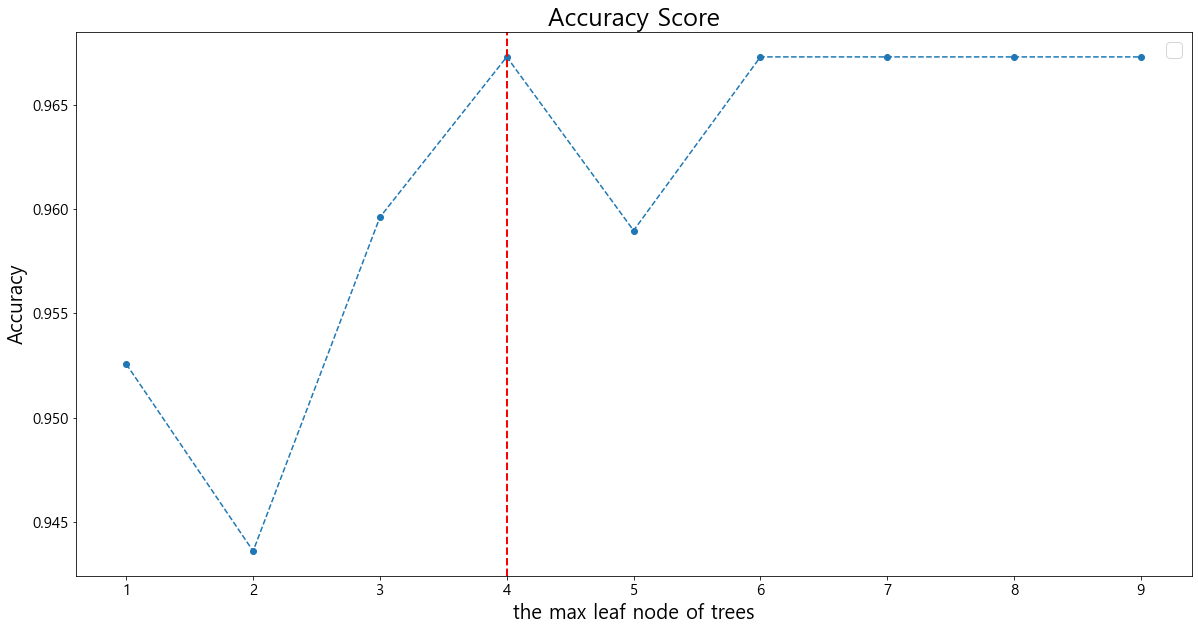

In [ ]:
cv_scores = []
estimator_list =[i for i in range(1,10,1)]
for i in tqdm(range(1,10,1)):
    rfc = RandomForestClassifier(n_estimators=29,
                                 max_depth=3,
                                 max_leaf_nodes=i+1,
                                 n_jobs=-1,
                                 random_state=2021)
    score = cross_val_score(rfc, X_train, y_train, cv=10, scoring = 'accuracy').mean()
    cv_scores.append(score)

best_e = [estimator_list[i] for i in range(len(cv_scores)) if cv_scores[i] == np.max(cv_scores)]
plt.figure(figsize=(20,10))
plt.legend(["Cross validation scores"], fontsize=20)
plt.plot(estimator_list,cv_scores, marker='o', linestyle='dashed')
plt.xlabel("the max leaf node of trees", fontsize=20 )
plt.ylabel("Accuracy", fontsize=20)
plt.title("Accuracy Score", fontsize=25)
plt.axvline(best_e[0], color='r', linestyle='--', linewidth=2)
plt.show()

In [ ]:
print(f"최적의 max_leaf_nodes:{estimator_list[cv_scores.index(max(cv_scores))]}")
print("\n")  
print("Train set에 대한 성능 (10 fold cross validation)")  
print(f"정확도:{max(cv_scores):0.4f}")  

최적의 max_leaf_nodes:4


Train set에 대한 성능 (10 fold cross validation)
정확도:0.9673


In [ ]:
rfc = RandomForestClassifier(n_estimators=29,max_depth=3,max_leaf_nodes=4, n_jobs=-1, random_state=2021)
rfc.fit(X_train, y_train)

# Train set에 대한 성능
y_pred = rfc.predict(X_train)
acc = accuracy_score(y_true = y_train, y_pred =y_pred)
print("Train set에 대한 성능")  
print(f"정확도:{acc:0.4f}")  

# Test set에 대한 성능
y_pred = rfc.predict(X_test)
acc = accuracy_score(y_true = y_test, y_pred =y_pred)
print("\n")  
print("Test set에 대한 성능")  
print(f"정확도:{acc:0.4f}")  

Train set에 대한 성능
정확도:0.9839


Test set에 대한 성능
정확도:1.0000


 리프노드의 최대 개수의 경우는 위와 같은 결과를 보인다. 4까지는 증가하다가 잠깐 하락후 다시 증가하여 일정 수준을 유지한다. 역시 이번에 얻은 최적의 최대 리프노드 수 4개와 앞서 얻은 max depth=3과 앞서 파악한 최적의 tree 개수 29개를 함께 적용하여 새로운 모델을 학습시킨 결과는 training dataset: 0.9839, testing dataset: 1.0이다.

## 2.4 전체 하이퍼 파라미터 Grid search
 앞서 각각의 하이퍼파라미터에대한 예측성능의 변화를 살펴보았으니, 이번엔 모든 하이퍼 파라미터들을 한 번에 변화시키며 최적의 조합을 탐색해보자. 다음은 각각 하이퍼파라미터의 탐색 범위이다. 이는 앞선 개별분석에서 얻은 최적의 위치를 중심으로 하였다.

In [ ]:
rfc = RandomForestClassifier(random_state=2021)
param_grid = {
    'n_estimators': [20,27,28,29,30,31,40, 60, 70],
    'max_depth': [2,3,4,5,6,10,20,30],
    'max_leaf_nodes': [2,3,4,5,6,10,20,40],
    'criterion':['gini', 'entropy'],
    'max_features':['auto','sqrt', 'log2']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=10, verbose=1 ,n_jobs=-1) #-1이 내 컴퓨터 자원 최대로 사용한다는 뜻
CV_rfc.fit(X_train, y_train)

Fitting 10 folds for each of 3456 candidates, totalling 34560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:   58.5s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=2021),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5, 6, 10, 20, 30],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'max_leaf_nodes': [2, 3, 4, 5, 6, 10, 20, 40],
                         'n_estimators': [20, 27, 28, 29, 30, 31, 40, 60, 70]},
             verbose=1)

 위 분석에는 앞서 설명하지 않은 criterion, max_features가 포함되었는데, 이는 각각 어떤 성능지표를 기준으로 할것인가와, 최적의 분할을 위해 고려할 최대의 fearture수이다.
 위의 GridSearchCV를 수행하면 아래와 같이 각각의 하이퍼 파라미터 조합에 대한 예측 성능을 얻을 수 있다. 


In [ ]:
# 최적의 하이퍼 파라미터 셋
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 3,
 'max_features': 'auto',
 'max_leaf_nodes': 5,
 'n_estimators': 29}

위 파라미터를 바로 사용할 수도 있으나 확인차 각 파라미터 조합별 성능을 다음과 같이 확인 할 수도 있다.

In [ ]:
result_table = pd.DataFrame(CV_rfc.cv_results_)
result_table = result_table.sort_values(by='mean_test_score', ascending=False)
print(result_table[['params', 'mean_test_score']])

                                                 params  mean_test_score
1221  {'criterion': 'gini', 'max_depth': 10, 'max_fe...         0.967308
1487  {'criterion': 'gini', 'max_depth': 20, 'max_fe...         0.967308
1485  {'criterion': 'gini', 'max_depth': 20, 'max_fe...         0.967308
1482  {'criterion': 'gini', 'max_depth': 20, 'max_fe...         0.967308
326   {'criterion': 'gini', 'max_depth': 3, 'max_fea...         0.967308
...                                                 ...              ...
1951  {'criterion': 'entropy', 'max_depth': 3, 'max_...         0.927564
3178  {'criterion': 'entropy', 'max_depth': 20, 'max...         0.927564
1792  {'criterion': 'entropy', 'max_depth': 2, 'max_...         0.927564
1807  {'criterion': 'entropy', 'max_depth': 2, 'max_...         0.927564
2959  {'criterion': 'entropy', 'max_depth': 10, 'max...         0.927564

[3456 rows x 2 columns]


그 결과 최종적으로 얻은 최적의 하이퍼파라미터 조합에서의 예측 결과는 다음과 같다.

In [ ]:
best_rfc = CV_rfc.best_estimator_
best_rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, max_leaf_nodes=5, n_estimators=29,
                       random_state=2021)

In [ ]:
# Train set에 대한 성능
y_pred = best_rfc.predict(X_train)
acc = accuracy_score(y_true = y_train, y_pred =y_pred)
print("Train set에 대한 성능")  
print(f"정확도:{acc:0.4f}")  

# Test set에 대한 성능
y_pred = best_rfc.predict(X_test)
acc = accuracy_score(y_true = y_test, y_pred =y_pred)
print("\n")  
print("Test set에 대한 성능")  
print(f"정확도:{acc:0.4f}")  

Train set에 대한 성능
정확도:0.9839


Test set에 대한 성능
정확도:1.0000


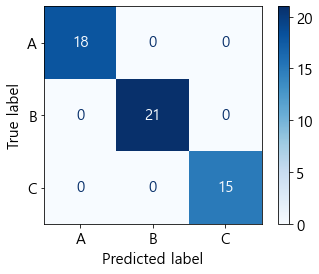

In [ ]:
plot_confusion_matrix(best_rfc, X_test, y_test, cmap=plt.cm.Blues)
plt.show()  

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       1.00      1.00      1.00        18
           B       1.00      1.00      1.00        21
           C       1.00      1.00      1.00        15

    accuracy                           1.00        54
   macro avg       1.00      1.00      1.00        54
weighted avg       1.00      1.00      1.00        54



## 2.5 Feature Importance 추출

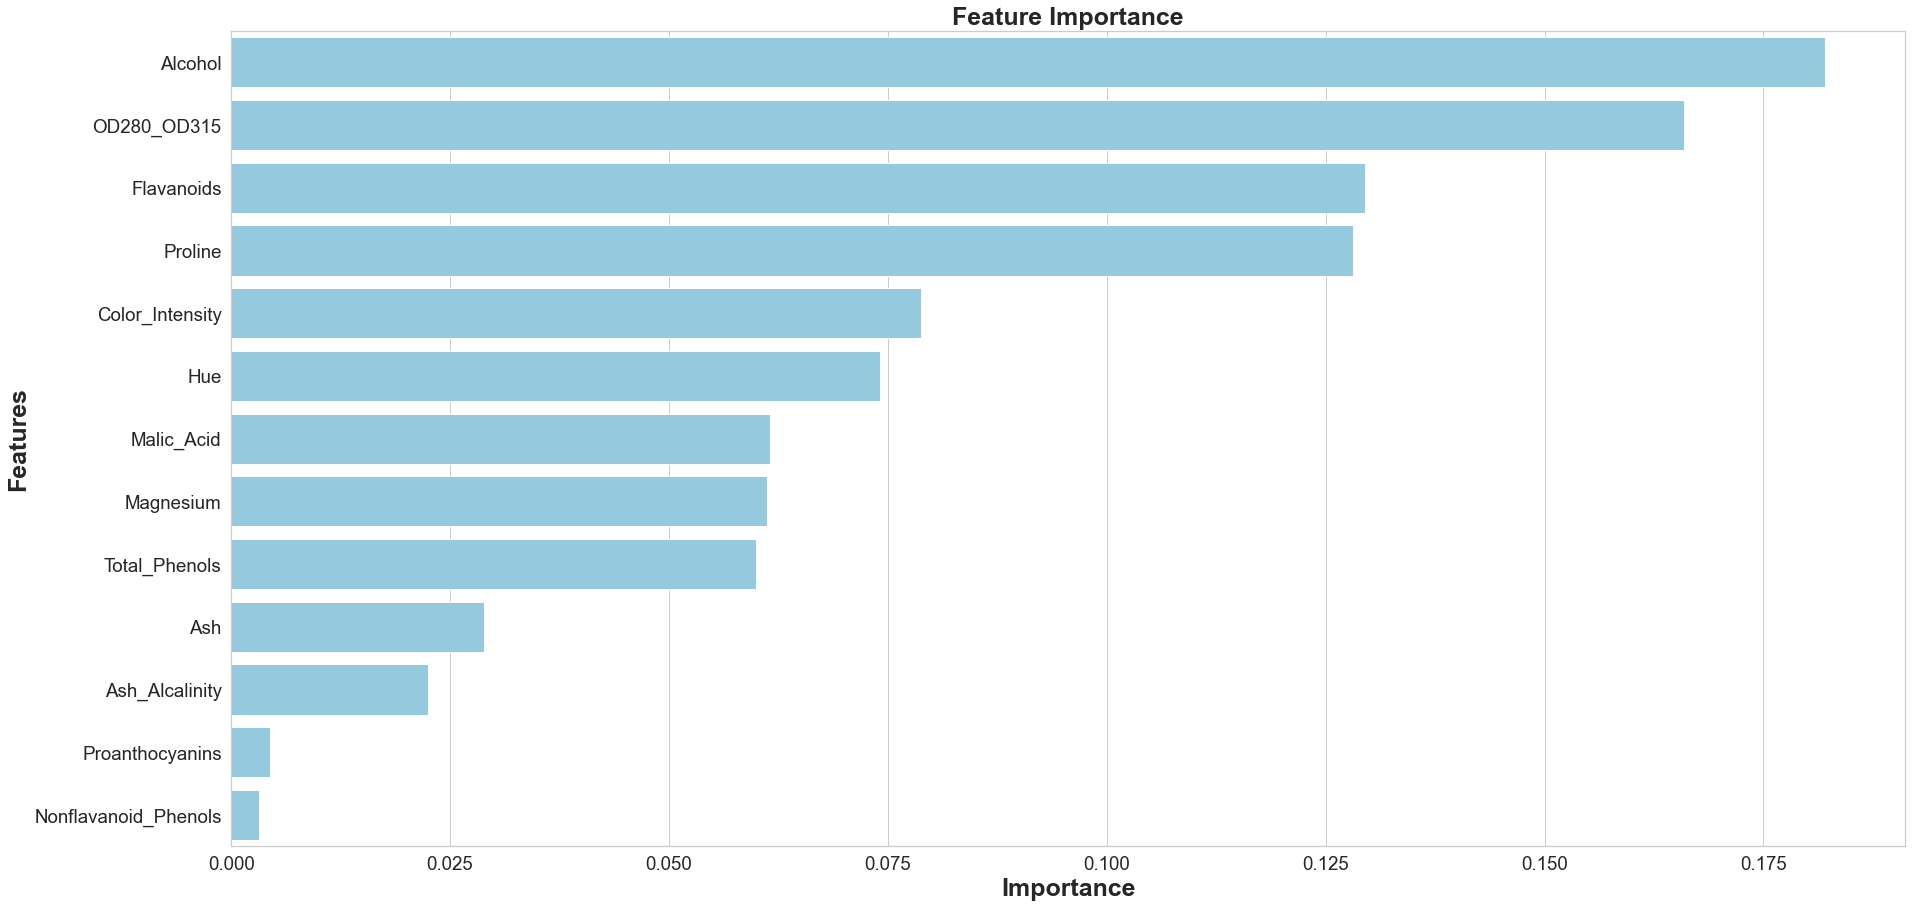

None

,Features,Gini-Importance
0,Alcohol,0.182087
1,OD280_OD315,0.165919
2,Flavanoids,0.129467
3,Proline,0.128157
4,Color_Intensity,0.078745
5,Hue,0.074096
6,Malic_Acid,0.061530
7,Magnesium,0.061161
8,Total_Phenols,0.059905
9,Ash,0.028819


In [ ]:
feats = {}
for feature, importance in zip(X_train.columns.tolist(), best_rfc.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)

랜덤 포레스트 모델로 부터 중요 변수를 추출한 결과이다.  
그래프와 표는 내림차순으로 정렬한 것으로 Gini-Importance를 기준으로 frarture의 중요도를 판단 한것이다.
결과 Alcohol이 이번 데이터를 분류하는데 가장 중요한 역할을 수행하였으며, 그 이후로 OD280_OD315, Flavanoids, Proline순이다. 그 다음은 표를 참고하면 된다. 랜덤포레스트 또한 학습하는 training data를 샘플링하는 과정에서 수행시마다 결과가 조금은 다를 수가 있었다. 그때마다 feature importance의 결과도 조금씩은 달라졌다. 그러나 정말 큰영향을 주는 상위 feature들은 계속해서 중요한 역할을 하는 것으로 결과가 나왔으니 상위 feature들만 확실하게 중요변수로 파악하는 것도 좋을 것이다.


## 2.6 Wine data를 통한 RF와 Boosting계열 모델의 비교
앞서 수행한 MNIST 데이터와 동일하게 boosting 모델 구축,
- Light GBM
- Catboost

두 모델의 비교 수행

In [ ]:
# 데이터 컬럼 단위 정규화 하기 
normalizer = StandardScaler()
X_train_scaled = normalizer.fit_transform(X_train)
X_test_scaled = normalizer.transform(X_test)

 같은 데이터에 대한 부스팅 모델의 성능을 비교하기위해 이번 분석에서는 Light GBM과 Catboost를 이용하였다. 최적의 하이퍼파라미터를 충분히 탐색하여 예측을 수행한 랜덤포레스트와 공평한 비교를 위해 Light GBM과 Catboost도 다음과 같은 하이퍼 파라미터의 범위를 탐색하여 최적의 조건에서 얻은 결과를 통해 비교를 수행하였다.

In [ ]:
## 탐색하고자 하는 하이퍼파라미터 설정 ## 
model_params = {'Light GBM' : {'model' : LGBMClassifier(random_state=0, silent=True, device='gpu') if device == True else LGBMClassifier(random_state=0, silent=True),
                          'params' : {'max_depth':[i for i in range(1,11,2)],
                                      'n_estimators':[50*(i+1) for i in range(3)],
                                      'learning_rate': [0.2*(i+1) for i in range(3)]
                                     }},
                
                'Catboost' : {'model' : CatBoostClassifier(random_seed=0, silent=True, task_type = 'GPU', thread_count = 5 , gpu_ram_part = .5) if device == True else CatBoostClassifier(random_seed=0, silent=True), 
                              'params' : {'max_depth':[i for i in range(1,11,2)] ,
                                          'n_estimators':[50*(i+1) for i in range(3)],
                                          'learning_rate': [0.2*(i+1) for i in range(3)]
                                     }}
                                    }

In [ ]:
pbar = tqdm(total=len(model_params))
output = pd.DataFrame([])

In [ ]:
# 2가지 모델에 대한 학습 시작 # 
for model_name, v in model_params.items():

    pbar.set_description(desc=f"{model_name}") # tqdm에서 활용되는 옵션입니다. 현재 학습되고 있는 모델 이름을 출력합니다.
        
    model, params = v['model'], v['params']
    gcv = GridSearchCV(estimator=model, param_grid=params, n_jobs=2 if model_name == 'Catboost' else 5, cv=3, scoring='accuracy')
    gcv.fit(X_train_scaled, y_train)
        
    result = pd.DataFrame.from_dict(gcv.cv_results_) # cv_results에는 각 fold별 예측 성능이 기록되어 있습니다.
    result['test_accuracy_with_best_hyp'] = accuracy_score(y_pred = gcv.predict(X_test_scaled) , y_true = y_test) #gcv.predict()는 최적 하이퍼파라미터가 탑재된 모델의 예측 결과를 파악하는데 사용됩니다.
    result['model_name'] = model_name
    result['seed'] = 0
    output = pd.concat([output,result])
    pbar.update(1)

output.reset_index(drop=True)       
output.to_csv('./classification_resul_wine(hw8).csv')

In [ ]:
show_result('Light GBM')

In [ ]:
show_result('Catboost')

In [ ]:
output.reset_index(drop=True,inplace=True) # index 초기화
plt.figure(figsize=(10,10))

idx = output.groupby(['model_name'])['mean_test_score'].idxmax() # 각 모델별 검증용 accuracy를 기준하여, Best 성능을 기록한 경우 추출
output.loc[idx,['model_name','test_accuracy_with_best_hyp']].set_index('model_name').plot.bar(legend=False)
plt.title('Predictive performance of models with optimal hyperparameters',fontsize=10)
plt.yticks(fontsize=20)
plt.show()

<p align="center">   <image src="./images/2022-12-01-22-51-25.png"/>   </p>

 위 범위를 탐색한 결과 다음과 같이 Light GBM은 예측 정확도가 1.0이 되었으며 Catboost의 경우는 0.96정도의 성능을 보였다. 

In [ ]:
output.loc[idx,['model_name','test_accuracy_with_best_hyp']]

In [ ]:
## 탐색하고자 하는 하이퍼파라미터 설정 ## 
model_params = {'Catboost' : {'model' : CatBoostClassifier(random_seed=0, silent=True, task_type = 'GPU', thread_count = 5 , gpu_ram_part = .5) if device == True else CatBoostClassifier(random_seed=0, silent=True), 
                              'params' : {'max_depth':[i for i in range(8,20,2)] ,
                                          'n_estimators':[50*(i+1) for i in range(3)],
                                          'learning_rate': list(np.arange(0.05,0.20,0.01))
                                     }}
                                    }
pbar = tqdm(total=len(model_params)) 
output = pd.DataFrame([])

In [ ]:
# catboost 개선판 모델에 대한 학습 시작 # 
for model_name, v in model_params.items():

    pbar.set_description(desc=f"{model_name}") # tqdm에서 활용되는 옵션입니다. 현재 학습되고 있는 모델 이름을 출력합니다.
        
    model, params = v['model'], v['params']
    gcv = GridSearchCV(estimator=model, param_grid=params, n_jobs=2 if model_name == 'Catboost' else 5, cv=3, scoring='accuracy')
    gcv.fit(X_train_scaled, y_train)
        
    result = pd.DataFrame.from_dict(gcv.cv_results_) # cv_results에는 각 fold별 예측 성능이 기록되어 있습니다.
    result['test_accuracy_with_best_hyp'] = accuracy_score(y_pred = gcv.predict(X_test_scaled) , y_true = y_test) #gcv.predict()는 최적 하이퍼파라미터가 탑재된 모델의 예측 결과를 파악하는데 사용됩니다.
    result['model_name'] = model_name
    result['seed'] = 0
    output = pd.concat([output,result])
    pbar.update(1)

output.reset_index(drop=True)       
output.to_csv('./classification_resul_wine(hw8)2.csv')

 Catboost의 경우 하이퍼파라미터를 조금 더 최적화 할 수 있을 것으로 판단되어 다음과 같은 범위로 재탐색을 수행했고 그 결과 다음과 같이 0.98의 성능을 얻을 수 있었다.

In [ ]:
output.loc[idx,['model_name','test_accuracy_with_best_hyp']]

 즉, 랜덤포레스트: 1.0, Light GBM: 1.0, Catboost:0.9815의 성능을 얻었다. 이는 모두 높은 분류 성능으로 사용하는 변수에 다양성을 주는 랜덤포레스트 방식과 사용하는 instance에 다양성을 주는 부스팅 방식 모두 분류에 대해서 높은 성능을 보여준다는 것을 확인할 수 있었다. 비슷한 성능을 보인다면 변수의 중요도를 파악하기 좋은 랜덤 포레스트의 경우가 XAI 구현의 측면에서 더 활용도가 높다는 생각이 들기도한다.

# 3. Cereals
- Random Forest Regression 구현 및 하이퍼 파라미터 탐색
- Boosting 계열 모델과의 비교

본 데이터로 모델을 구현, 파라미터 탐색을 수행하는 과정은 이전까지 다른 두 데이터에서 수행한 과정과 거의 동일하므로 설명을 많이 생략하였다. 

## 3.1 data

In [ ]:
# 데이터 로드 
cereals =pd.read_excel('Cereals.xls', sheet_name=1)

In [ ]:
print(f'관측치 수 : {cereals.shape[0]} \n변수 수 : {cereals.shape[1]}')

관측치 수 : 77 
변수 수 : 16


In [ ]:
# 누락 값을 제외 하고 분석에 불필요한 이름 column을 제외한다.
cereals = cereals.dropna(axis=0)
cereals=cereals.drop('name',axis=1)

In [ ]:
target = ['rating']
print(target)
category_feature = [col for col in cereals.columns if cereals[col].dtype == "object"]
print(category_feature)

numeric_feature = list(set(cereals.columns) - set(target)-set(category_feature))
print(numeric_feature)

['rating']
['mfr', 'type']
['calories', 'shelf', 'vitamins', 'fiber', 'potass', 'weight', 'sodium', 'fat', 'protein', 'cups', 'sugars', 'carbo']


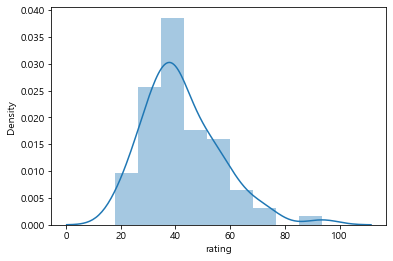

In [ ]:
f = sns.distplot(cereals['rating'])

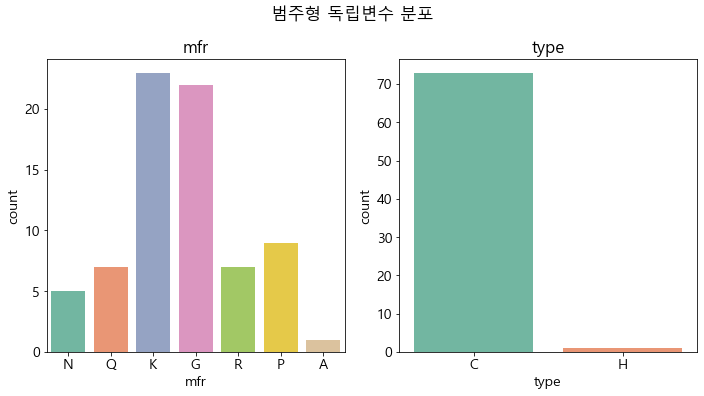

In [ ]:
#범주형 종속변수 확인
fig = plt.figure(figsize=(10,10))
plt.rc('font', size=14)
fig.suptitle('범주형 독립변수 분포')

for i in range(len(category_feature)):
    ax = fig.add_subplot(2,2,i+1)
    ax = sns.countplot(cereals[category_feature[i]],palette='Set2')
    plt.title(category_feature[i])
fig.tight_layout()
plt.show()

 범주형 독립변수인 mfr, type의 경우 one-hot encoding을 수행한다. shelf는 순서형이므로 그대로 사용이가능하다.

In [ ]:
X = cereals.drop('rating', axis=1)
y = pd.DataFrame(cereals['rating'])
X

,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups
0,N,C,70,4,1,130,10.0,5.0,6.0,280.0,25,3,1.0,0.33
1,Q,C,120,3,5,15,2.0,8.0,8.0,135.0,0,3,1.0,1.00
2,K,C,70,4,1,260,9.0,7.0,5.0,320.0,25,3,1.0,0.33
3,K,C,50,4,0,140,14.0,8.0,0.0,330.0,25,3,1.0,0.50
5,G,C,110,2,2,180,1.5,10.5,10.0,70.0,25,1,1.0,0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,G,C,110,2,1,250,0.0,21.0,3.0,60.0,25,3,1.0,0.75
73,G,C,110,1,1,140,0.0,13.0,12.0,25.0,25,2,1.0,1.00
74,R,C,100,3,1,230,3.0,17.0,3.0,115.0,25,1,1.0,0.67
75,G,C,100,3,1,200,3.0,17.0,3.0,110.0,25,1,1.0,1.00


In [ ]:
X=pd.get_dummies(X)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74 entries, 0 to 76
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calories  74 non-null     int64  
 1   protein   74 non-null     int64  
 2   fat       74 non-null     int64  
 3   sodium    74 non-null     int64  
 4   fiber     74 non-null     float64
 5   carbo     74 non-null     float64
 6   sugars    74 non-null     float64
 7   potass    74 non-null     float64
 8   vitamins  74 non-null     int64  
 9   shelf     74 non-null     int64  
 10  weight    74 non-null     float64
 11  cups      74 non-null     float64
 12  mfr_A     74 non-null     uint8  
 13  mfr_G     74 non-null     uint8  
 14  mfr_K     74 non-null     uint8  
 15  mfr_N     74 non-null     uint8  
 16  mfr_P     74 non-null     uint8  
 17  mfr_Q     74 non-null     uint8  
 18  mfr_R     74 non-null     uint8  
 19  type_C    74 non-null     uint8  
 20  type_H    74 non-null     uint8  


In [ ]:
# Train set/ Test set 나누기 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=2021)


print(f'Train set dimension is {X_train.shape}')
print(f'Test set dimension is {X_test.shape}')

Train set dimension is (59, 21)
Test set dimension is (15, 21)


## 3.2 RandomForest Regression modeling

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

In [ ]:
rfr = RandomForestRegressor(n_estimators=10,random_state=2021)
rfr.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=2021)

In [ ]:
# Train set에 대한 성능
y_train_pred = rfr.predict(X_train)

train_r2score = r2_score(y_true = y_train, y_pred =y_train_pred) ## R-squared score
train_mse = mean_squared_error(y_true = y_train, y_pred =y_train_pred) ## MSE (Mean Squared Error)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_true = y_train, y_pred =y_train_pred) ## MAE (Mean Absolute Error)
train_mape = mean_absolute_percentage_error(y_train, y_train_pred)

print("Train set에 대한 성능")  
print(f"R2 score:{train_r2score:0.4f}",f"MSE:{train_mse:0.4f}",f"MAE:{train_mae:0.4f}", sep='  |  ')  
print(f'Training RMSE: {train_rmse:.3f}')
print(f'Training MAPE: {train_mape:.3f}')

# Test set에 대한 성능
y_test_pred = rfr.predict(X_test)

test_r2score = r2_score(y_true = y_test, y_pred =y_test_pred) ## R-squared score
test_mse = mean_squared_error(y_true = y_test, y_pred =y_test_pred) ## MSE (Mean Squared Error)
test_rmse= np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_true = y_test, y_pred =y_test_pred) ## MAE (Mean Absolute Error)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

print("\n")  
print("Test set에 대한 성능")  
print(f"R2 score:{test_r2score:0.4f}",f"MSE:{test_mse:0.4f}",f"MAE:{test_mae:0.4f}", sep='  |  ')  
print(f'Testing RMSE: {test_rmse:.3f}')
print(f'Testing MAPE: {test_mape:.3f}')


Train set에 대한 성능
R2 score:0.9672  |  MSE:5.6443  |  MAE:1.6602
Training RMSE: 2.376
Training MAPE: 37.409


Test set에 대한 성능
R2 score:0.6570  |  MSE:94.7712  |  MAE:5.6810
Testing RMSE: 9.735
Testing MAPE: 35.547


## 3.3 단일 하이퍼 파라미터에 대한 Grid search
- n_estimator
- the max depth of tree
- the max leaf node of tree

### 3.3.1 n_estimator

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:33<00:00,  1.50it/s]


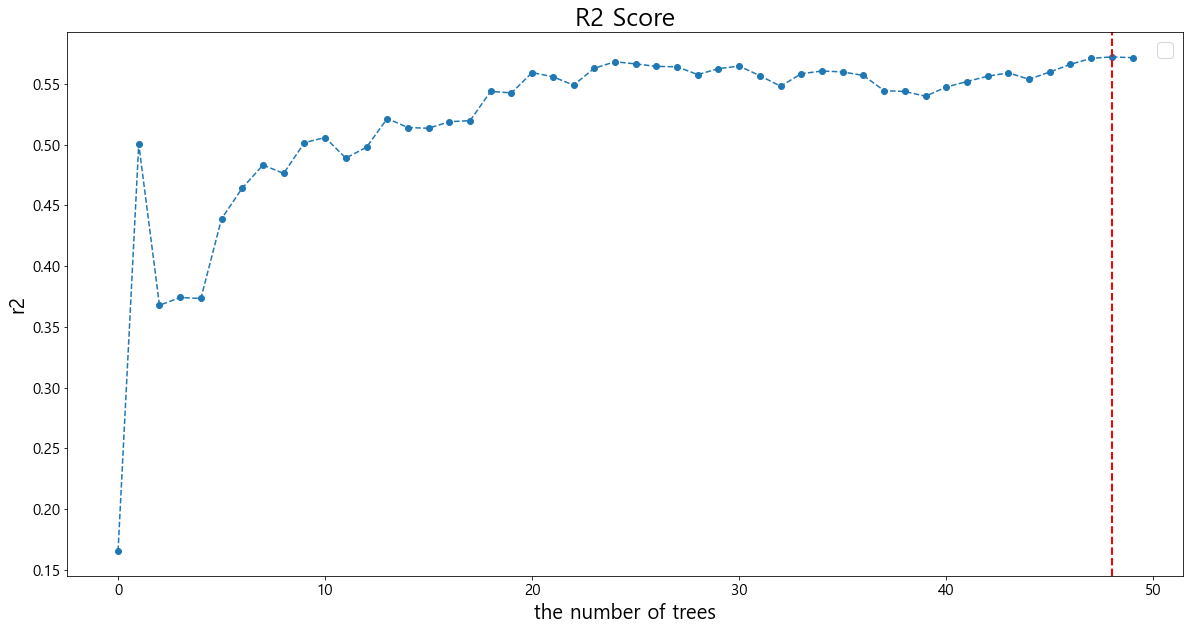

In [ ]:
cv_scores = []
estimator_list =[i for i in range(0,50,1)]
for i in tqdm(range(0,50,1)):
    rfr = RandomForestRegressor(n_estimators=i+1,
                                 n_jobs=-1,
                                 random_state=2021)
    score = cross_val_score(rfr, X_train, y_train, cv=10, scoring = 'r2').mean()
    cv_scores.append(score)

best_e = [estimator_list[i] for i in range(len(cv_scores)) if cv_scores[i] == np.max(cv_scores)]
plt.figure(figsize=(20,10))
plt.legend(["Cross validation scores"], fontsize=20)
plt.plot(estimator_list,cv_scores, marker='o', linestyle='dashed')
plt.xlabel("the number of trees", fontsize=20 )
plt.ylabel("r2", fontsize=20)
plt.title("R2 Score", fontsize=25)
plt.axvline(best_e[0], color='r', linestyle='--', linewidth=2)
plt.show()

In [ ]:
print(f"최적의 tree개수:{(cv_scores.index(max(cv_scores)))+1}")
print("\n")  
print("Train set에 대한 성능 (10 fold cross validation)")  
print(f"R2:{max(cv_scores):0.4f}")  

최적의 tree개수:49


Train set에 대한 성능 (10 fold cross validation)
R2:0.5723


In [ ]:
opti_n_estimators=(cv_scores.index(max(cv_scores)))+1

rfr = RandomForestRegressor(n_estimators=opti_n_estimators, n_jobs=-1, random_state=2021)
rfr.fit(X_train, y_train)

# Train set에 대한 성능
y_train_pred = rfr.predict(X_train)

train_r2score = r2_score(y_true = y_train, y_pred =y_train_pred) ## R-squared score
train_mse = mean_squared_error(y_true = y_train, y_pred =y_train_pred) ## MSE (Mean Squared Error)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_true = y_train, y_pred =y_train_pred) ## MAE (Mean Absolute Error)
train_mape = mean_absolute_percentage_error(y_train, y_train_pred)

print("Train set에 대한 성능")  
print(f"R2 score:{train_r2score:0.4f}",f"MSE:{train_mse:0.4f}",f"MAE:{train_mae:0.4f}", sep='  |  ')  
print(f'Training RMSE: {train_rmse:.3f}')
print(f'Training MAPE: {train_mape:.3f}')

# Test set에 대한 성능
y_test_pred = rfr.predict(X_test)

test_r2score = r2_score(y_true = y_test, y_pred =y_test_pred) ## R-squared score
test_mse = mean_squared_error(y_true = y_test, y_pred =y_test_pred) ## MSE (Mean Squared Error)
test_rmse= np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_true = y_test, y_pred =y_test_pred) ## MAE (Mean Absolute Error)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

print("\n")  
print("Test set에 대한 성능")  
print(f"R2 score:{test_r2score:0.4f}",f"MSE:{test_mse:0.4f}",f"MAE:{test_mae:0.4f}", sep='  |  ')  
print(f'Testing RMSE: {test_rmse:.3f}')
print(f'Testing MAPE: {test_mape:.3f}')

Train set에 대한 성능
R2 score:0.9784  |  MSE:3.7196  |  MAE:1.4811
Training RMSE: 1.929
Training MAPE: 37.484


Test set에 대한 성능
R2 score:0.6802  |  MSE:88.3401  |  MAE:5.2253
Testing RMSE: 9.399
Testing MAPE: 35.568


In [ ]:
rfr = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=2021)
rfr.fit(X_train, y_train)

# Train set에 대한 성능
y_train_pred = rfr.predict(X_train)

train_r2score = r2_score(y_true = y_train, y_pred =y_train_pred) ## R-squared score
train_mse = mean_squared_error(y_true = y_train, y_pred =y_train_pred) ## MSE (Mean Squared Error)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_true = y_train, y_pred =y_train_pred) ## MAE (Mean Absolute Error)
train_mape = mean_absolute_percentage_error(y_train, y_train_pred)

print("Train set에 대한 성능")  
print(f"R2 score:{train_r2score:0.4f}",f"MSE:{train_mse:0.4f}",f"MAE:{train_mae:0.4f}", sep='  |  ')  
print(f'Training RMSE: {train_rmse:.3f}')
print(f'Training MAPE: {train_mape:.3f}')

# Test set에 대한 성능
y_test_pred = rfr.predict(X_test)

test_r2score = r2_score(y_true = y_test, y_pred =y_test_pred) ## R-squared score
test_mse = mean_squared_error(y_true = y_test, y_pred =y_test_pred) ## MSE (Mean Squared Error)
test_rmse= np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_true = y_test, y_pred =y_test_pred) ## MAE (Mean Absolute Error)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

print("\n")  
print("Test set에 대한 성능")  
print(f"R2 score:{test_r2score:0.4f}",f"MSE:{test_mse:0.4f}",f"MAE:{test_mae:0.4f}", sep='  |  ')  
print(f'Testing RMSE: {test_rmse:.3f}')
print(f'Testing MAPE: {test_mape:.3f}')

Train set에 대한 성능
R2 score:0.9805  |  MSE:3.3569  |  MAE:1.4471
Training RMSE: 1.832
Training MAPE: 37.402


Test set에 대한 성능
R2 score:0.6904  |  MSE:85.5473  |  MAE:5.3328
Testing RMSE: 9.249
Testing MAPE: 35.845


그래프 상에서 성능이 최고점에 도달하지 않을 것 같은 모양이 나타나 개별적으로 100,200인 경우도 실험해 보았으니 비슷한 성능으로 더 이상 하이퍼 파라미터를 증가시켜도 계산량 증가에 비해 성능 향상이 미비할 것을 예상할 수 있어 우선 tree의 수를 100이 최적의 지점으로 넘어간다. 결과적으로 이번 training dataset에서는 100개의 tree수가 최적의 지점이다.

### 3.3.2 max_depth

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.21s/it]


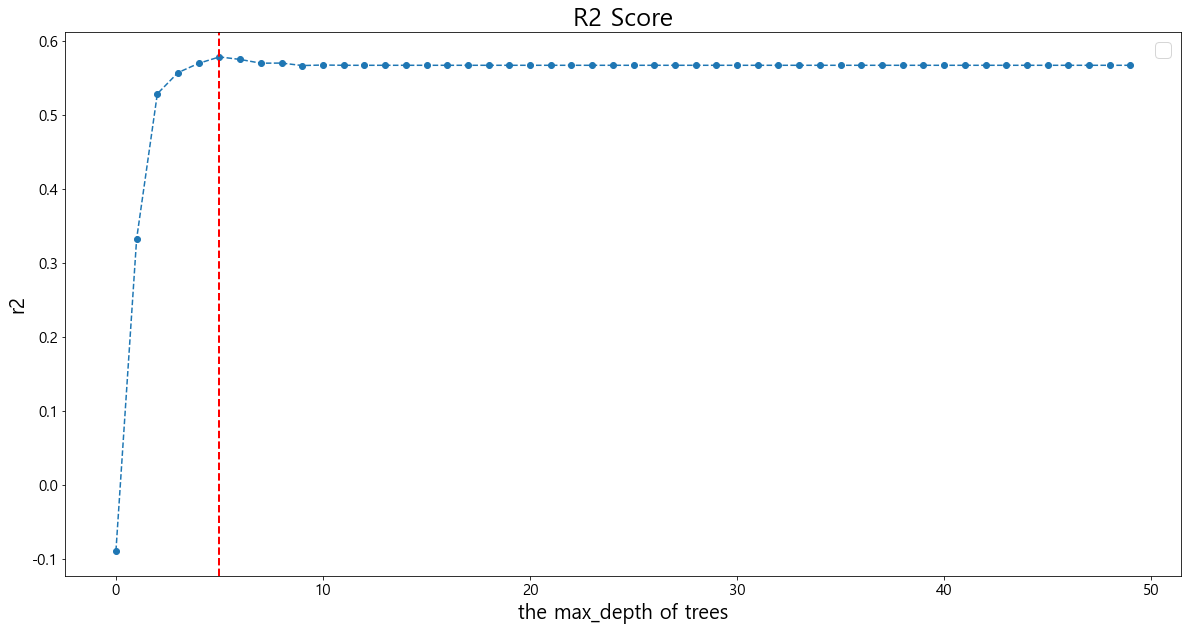

In [ ]:
cv_scores = []
estimator_list =[i for i in range(0,50,1)]
for i in tqdm(range(0,50,1)):
    rfr = RandomForestRegressor(n_estimators=100,
                                 max_depth=i+1,
                                 n_jobs=-1,
                                 random_state=2021)
    score = cross_val_score(rfr, X_train, y_train, cv=10, scoring = 'r2').mean()
    cv_scores.append(score)

best_e = [estimator_list[i] for i in range(len(cv_scores)) if cv_scores[i] == np.max(cv_scores)]
plt.figure(figsize=(20,10))
plt.legend(["Cross validation scores"], fontsize=20)
plt.plot(estimator_list,cv_scores, marker='o', linestyle='dashed')
plt.xlabel("the max_depth of trees", fontsize=20 )
plt.ylabel("r2", fontsize=20)
plt.title("R2 Score", fontsize=25)
plt.axvline(best_e[0], color='r', linestyle='--', linewidth=2)
plt.show()

In [ ]:
print(f"최적의 max_depth:{(cv_scores.index(max(cv_scores)))+1}")
print("\n")  
print("Train set에 대한 성능 (10 fold cross validation)")  
print(f"r2:{max(cv_scores):0.4f}")  

최적의 max_depth:6


Train set에 대한 성능 (10 fold cross validation)
r2:0.5787


In [ ]:
rfr = RandomForestRegressor(n_estimators=49,max_depth=6, n_jobs=-1, random_state=2021)
rfr.fit(X_train, y_train)

# Train set에 대한 성능
y_train_pred = rfr.predict(X_train)

train_r2score = r2_score(y_true = y_train, y_pred =y_train_pred) ## R-squared score
train_mse = mean_squared_error(y_true = y_train, y_pred =y_train_pred) ## MSE (Mean Squared Error)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_true = y_train, y_pred =y_train_pred) ## MAE (Mean Absolute Error)
train_mape = mean_absolute_percentage_error(y_train, y_train_pred)

print("Train set에 대한 성능")  
print(f"R2 score:{train_r2score:0.4f}",f"MSE:{train_mse:0.4f}",f"MAE:{train_mae:0.4f}", sep='  |  ')  
print(f'Training RMSE: {train_rmse:.3f}')
print(f'Training MAPE: {train_mape:.3f}')

# Test set에 대한 성능
y_test_pred = rfr.predict(X_test)

test_r2score = r2_score(y_true = y_test, y_pred =y_test_pred) ## R-squared score
test_mse = mean_squared_error(y_true = y_test, y_pred =y_test_pred) ## MSE (Mean Squared Error)
test_rmse= np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_true = y_test, y_pred =y_test_pred) ## MAE (Mean Absolute Error)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

print("\n")  
print("Test set에 대한 성능")  
print(f"R2 score:{test_r2score:0.4f}",f"MSE:{test_mse:0.4f}",f"MAE:{test_mae:0.4f}", sep='  |  ')  
print(f'Testing RMSE: {test_rmse:.3f}')
print(f'Testing MAPE: {test_mape:.3f}') 

Train set에 대한 성능
R2 score:0.9781  |  MSE:3.7569  |  MAE:1.5134
Training RMSE: 1.938
Training MAPE: 37.459


Test set에 대한 성능
R2 score:0.6783  |  MSE:88.8759  |  MAE:5.2299
Testing RMSE: 9.427
Testing MAPE: 35.362


### 3.3.3 max_leaf_nodes

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:19<00:00,  1.48it/s]


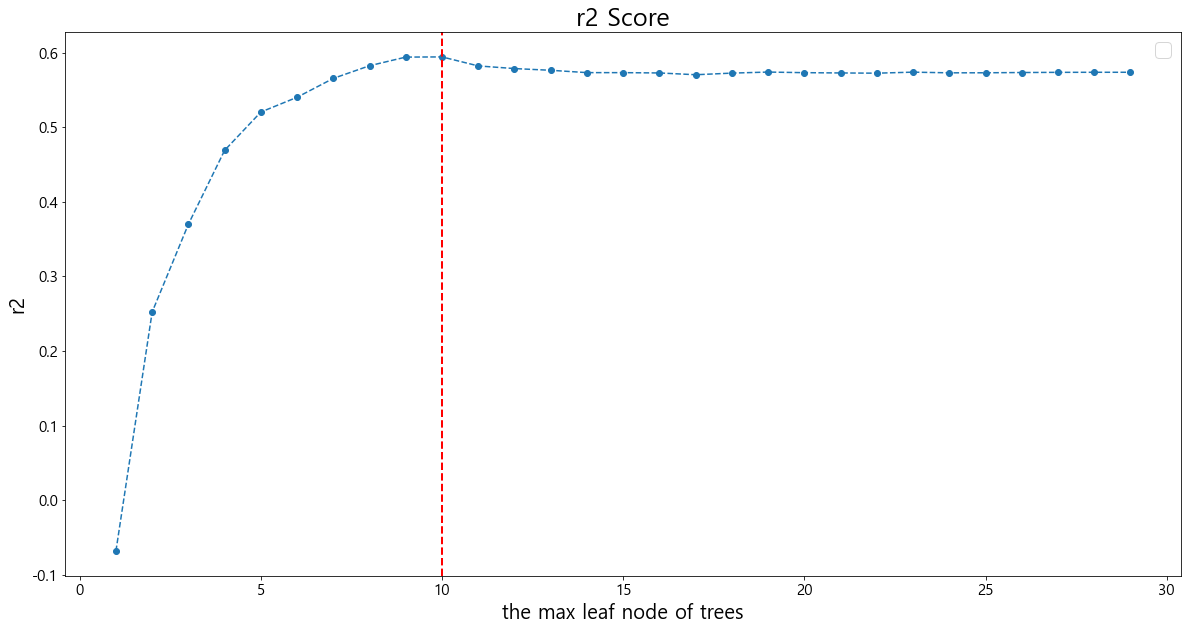

In [ ]:
cv_scores = []
estimator_list =[i for i in range(1,30,1)]
for i in tqdm(range(1,30,1)):
    rfr = RandomForestRegressor(n_estimators=49,
                                 max_depth=6,
                                 max_leaf_nodes=i+1,
                                 n_jobs=-1,
                                 random_state=2021)
    score = cross_val_score(rfr, X_train, y_train, cv=10, scoring = 'r2').mean()
    cv_scores.append(score)

best_e = [estimator_list[i] for i in range(len(cv_scores)) if cv_scores[i] == np.max(cv_scores)]
plt.figure(figsize=(20,10))
plt.legend(["Cross validation scores"], fontsize=20)
plt.plot(estimator_list,cv_scores, marker='o', linestyle='dashed')
plt.xlabel("the max leaf node of trees", fontsize=20 )
plt.ylabel("r2", fontsize=20)
plt.title("r2 Score", fontsize=25)
plt.axvline(best_e[0], color='r', linestyle='--', linewidth=2)
plt.show()

In [ ]:
print(f"최적의 max_leaf_nodes:{estimator_list[cv_scores.index(max(cv_scores))]}")
print("\n")  
print("Train set에 대한 성능 (10 fold cross validation)")  
print(f"r2:{max(cv_scores):0.4f}")  

최적의 max_leaf_nodes:10


Train set에 대한 성능 (10 fold cross validation)
r2:0.5945


## 3.4 전체 하이퍼 파라미터에 대한 Grid Search

In [ ]:
# Random Forest Regressor
rfr = RandomForestRegressor(random_state=2021)
param_grid = {
    'n_estimators': [20,40, 60],
    'max_depth': [5, 10, 15, 40],
    'max_leaf_nodes': [10, 15, 30 ,40],
    'criterion':['mae', 'mse'],
    'max_features':['auto','sqrt', 'log2']
}

CV_rfr = GridSearchCV(estimator=rfr, param_grid=param_grid, cv=10, verbose=1 ,n_jobs=12, scoring='r2')
CV_rfr.fit(X_train, y_train)

Fitting 10 folds for each of 288 candidates, totalling 2880 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    1.8s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    6.3s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:   10.8s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:   17.2s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:   25.8s
[Parallel(n_jobs=12)]: Done 1776 tasks      | elapsed:   35.1s
[Parallel(n_jobs=12)]: Done 2426 tasks      | elapsed:   46.4s
[Parallel(n_jobs=12)]: Done 2880 out of 2880 | elapsed:   55.3s finished


GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=2021),
             n_jobs=12,
             param_grid={'criterion': ['mae', 'mse'],
                         'max_depth': [5, 10, 15, 40],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'max_leaf_nodes': [10, 15, 30, 40],
                         'n_estimators': [20, 40, 60]},
             scoring='r2', verbose=1)

In [ ]:
# 최적의 하이퍼 파라미터 셋
CV_rfr.best_params_

{'criterion': 'mse',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': 30,
 'n_estimators': 60}

In [ ]:
result_table = pd.DataFrame(CV_rfr.cv_results_)
result_table = result_table.sort_values(by='mean_test_score', ascending=False)
print(result_table[['params', 'mean_test_score']])

                                                params  mean_test_score
212  {'criterion': 'mse', 'max_depth': 10, 'max_fea...         0.630600
200  {'criterion': 'mse', 'max_depth': 10, 'max_fea...         0.630600
203  {'criterion': 'mse', 'max_depth': 10, 'max_fea...         0.630358
215  {'criterion': 'mse', 'max_depth': 10, 'max_fea...         0.630358
236  {'criterion': 'mse', 'max_depth': 15, 'max_fea...         0.629807
..                                                 ...              ...
117  {'criterion': 'mae', 'max_depth': 40, 'max_fea...         0.416936
45   {'criterion': 'mae', 'max_depth': 10, 'max_fea...         0.416251
78   {'criterion': 'mae', 'max_depth': 15, 'max_fea...         0.416102
114  {'criterion': 'mae', 'max_depth': 40, 'max_fea...         0.416102
42   {'criterion': 'mae', 'max_depth': 10, 'max_fea...         0.415344

[288 rows x 2 columns]


In [ ]:
result_table[['params', 'mean_test_score']].head(3)

,params,mean_test_score
212,"{'criterion': 'mse', 'max_depth': 10, 'max_fea...",0.630600
200,"{'criterion': 'mse', 'max_depth': 10, 'max_fea...",0.630600
203,"{'criterion': 'mse', 'max_depth': 10, 'max_fea...",0.630358


위 성능을 기반으로 더 촘촘한 탐색을 수행한다.

In [ ]:
# Random Forest Regressor
rfr = RandomForestRegressor(random_state=2021)
param_grid = {
    'n_estimators': [45,50,55],
    'max_depth': [5,6,7,8, 9],
    'max_leaf_nodes': [31,32,33,34],
    'criterion':['mse'],
    'max_features':['sqrt']
}

CV_rfr = GridSearchCV(estimator=rfr, param_grid=param_grid, cv=10, verbose=1 ,n_jobs=12, scoring='r2')
CV_rfr.fit(X_train, y_train)

Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.6s
[Parallel(n_jobs=12)]: Done 328 tasks      | elapsed:    6.2s
[Parallel(n_jobs=12)]: Done 600 out of 600 | elapsed:   11.7s finished


GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=2021),
             n_jobs=12,
             param_grid={'criterion': ['mse'], 'max_depth': [5, 6, 7, 8, 9],
                         'max_features': ['sqrt'],
                         'max_leaf_nodes': [31, 32, 33, 34],
                         'n_estimators': [45, 50, 55]},
             scoring='r2', verbose=1)

In [ ]:
result_table = pd.DataFrame(CV_rfr.cv_results_)
result_table = result_table.sort_values(by='mean_test_score', ascending=False)
print(result_table[['params', 'mean_test_score']])

                                               params  mean_test_score
58  {'criterion': 'mse', 'max_depth': 9, 'max_feat...         0.654936
55  {'criterion': 'mse', 'max_depth': 9, 'max_feat...         0.654482
52  {'criterion': 'mse', 'max_depth': 9, 'max_feat...         0.654089
34  {'criterion': 'mse', 'max_depth': 7, 'max_feat...         0.652944
31  {'criterion': 'mse', 'max_depth': 7, 'max_feat...         0.652900
28  {'criterion': 'mse', 'max_depth': 7, 'max_feat...         0.652625
37  {'criterion': 'mse', 'max_depth': 8, 'max_feat...         0.652606
40  {'criterion': 'mse', 'max_depth': 8, 'max_feat...         0.652598
25  {'criterion': 'mse', 'max_depth': 7, 'max_feat...         0.652504
46  {'criterion': 'mse', 'max_depth': 8, 'max_feat...         0.652382
43  {'criterion': 'mse', 'max_depth': 8, 'max_feat...         0.652300
33  {'criterion': 'mse', 'max_depth': 7, 'max_feat...         0.652124
13  {'criterion': 'mse', 'max_depth': 6, 'max_feat...         0.652090
16  {'

In [ ]:
# 최적의 하이퍼 파라미터 셋
CV_rfr.best_params_

{'criterion': 'mse',
 'max_depth': 9,
 'max_features': 'sqrt',
 'max_leaf_nodes': 34,
 'n_estimators': 50}

In [ ]:
# Random Forest Regressor
rfr = RandomForestRegressor(random_state=2021)
param_grid = {
    'n_estimators': [46,47,48,49,50,51,52,53,54],
    'max_depth': [9],
    'max_leaf_nodes': [34],
    'criterion':['mse'],
    'max_features':['sqrt']
}

CV_rfr = GridSearchCV(estimator=rfr, param_grid=param_grid, cv=10, verbose=1 ,n_jobs=12, scoring='r2')
CV_rfr.fit(X_train, y_train)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  28 tasks      | elapsed:    0.6s
[Parallel(n_jobs=12)]: Done  67 out of  90 | elapsed:    1.2s remaining:    0.4s
[Parallel(n_jobs=12)]: Done  90 out of  90 | elapsed:    1.6s finished


GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=2021),
             n_jobs=12,
             param_grid={'criterion': ['mse'], 'max_depth': [9],
                         'max_features': ['sqrt'], 'max_leaf_nodes': [34],
                         'n_estimators': [46, 47, 48, 49, 50, 51, 52, 53, 54]},
             scoring='r2', verbose=1)

In [ ]:
result_table = pd.DataFrame(CV_rfr.cv_results_)
result_table = result_table.sort_values(by='mean_test_score', ascending=False)
print(result_table[['params', 'mean_test_score']])

                                              params  mean_test_score
7  {'criterion': 'mse', 'max_depth': 9, 'max_feat...         0.655002
4  {'criterion': 'mse', 'max_depth': 9, 'max_feat...         0.654936
6  {'criterion': 'mse', 'max_depth': 9, 'max_feat...         0.652891
5  {'criterion': 'mse', 'max_depth': 9, 'max_feat...         0.652027
2  {'criterion': 'mse', 'max_depth': 9, 'max_feat...         0.651084
8  {'criterion': 'mse', 'max_depth': 9, 'max_feat...         0.649667
3  {'criterion': 'mse', 'max_depth': 9, 'max_feat...         0.648543
1  {'criterion': 'mse', 'max_depth': 9, 'max_feat...         0.644700
0  {'criterion': 'mse', 'max_depth': 9, 'max_feat...         0.639511


In [ ]:
# 최적의 하이퍼 파라미터 셋
CV_rfr.best_params_

{'criterion': 'mse',
 'max_depth': 9,
 'max_features': 'sqrt',
 'max_leaf_nodes': 34,
 'n_estimators': 53}

In [ ]:
best_rfr = CV_rfr.best_estimator_
best_rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=9, max_features='sqrt', max_leaf_nodes=34,
                      n_estimators=53, random_state=2021)

In [ ]:
# Train set에 대한 성능
y_train_pred = best_rfr.predict(X_train)

train_r2score = r2_score(y_true = y_train, y_pred =y_train_pred) ## R-squared score
train_mse = mean_squared_error(y_true = y_train, y_pred =y_train_pred) ## MSE (Mean Squared Error)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_true = y_train, y_pred =y_train_pred) ## MAE (Mean Absolute Error)
train_mape = mean_absolute_percentage_error(y_train, y_train_pred)

print("Train set에 대한 성능")  
print(f"R2 score:{train_r2score:0.4f}",f"MSE:{train_mse:0.4f}",f"MAE:{train_mae:0.4f}", sep='  |  ')  
print(f'Training RMSE: {train_rmse:.3f}')
print(f'Training MAPE: {train_mape:.3f}')

# Test set에 대한 성능
y_test_pred = best_rfr.predict(X_test)

test_r2score = r2_score(y_true = y_test, y_pred =y_test_pred) ## R-squared score
test_mse = mean_squared_error(y_true = y_test, y_pred =y_test_pred) ## MSE (Mean Squared Error)
test_rmse= np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_true = y_test, y_pred =y_test_pred) ## MAE (Mean Absolute Error)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

print("\n")  
print("Test set에 대한 성능")  
print(f"R2 score:{test_r2score:0.4f}",f"MSE:{test_mse:0.4f}",f"MAE:{test_mae:0.4f}", sep='  |  ')  
print(f'Testing RMSE: {test_rmse:.3f}')
print(f'Testing MAPE: {test_mape:.3f}') 

Train set에 대한 성능
R2 score:0.9801  |  MSE:3.4138  |  MAE:1.3742
Training RMSE: 1.848
Training MAPE: 36.761


Test set에 대한 성능
R2 score:0.6395  |  MSE:99.5838  |  MAE:5.2944
Testing RMSE: 9.979
Testing MAPE: 32.157


## 3.5 Feature Importance 추출

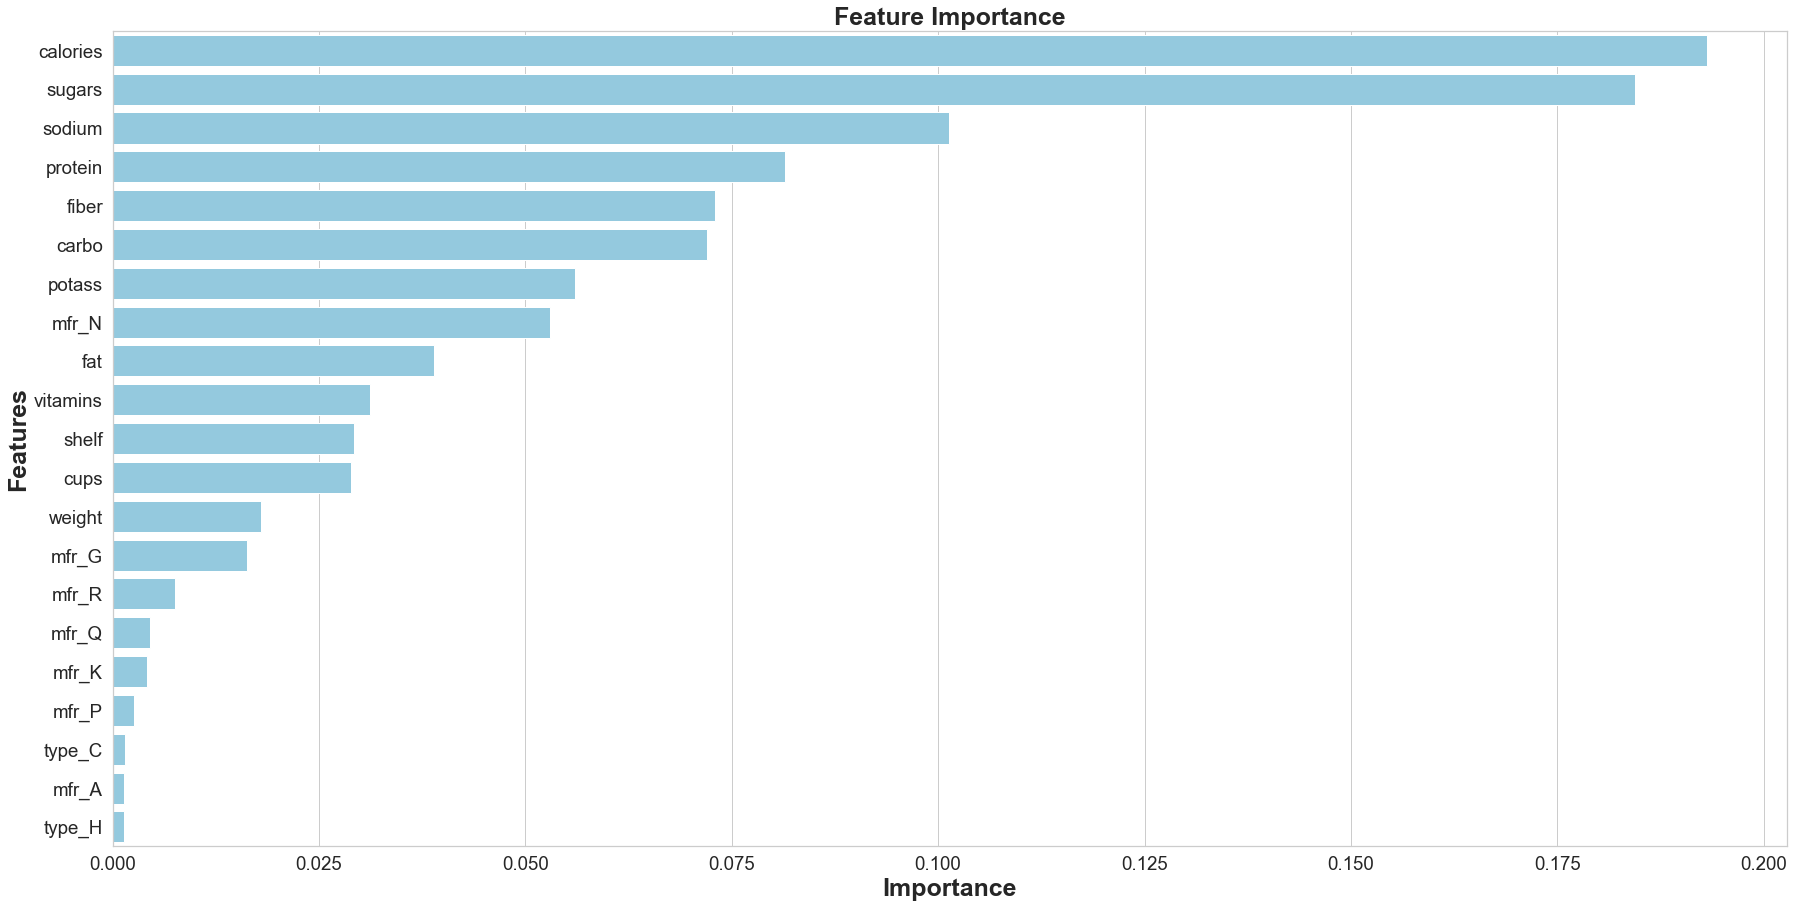

None

,Features,Gini-Importance
0,calories,0.193120
1,sugars,0.184406
2,sodium,0.101349
3,protein,0.081452
4,fiber,0.072928
5,carbo,0.071990
6,potass,0.055971
7,mfr_N,0.053036
8,fat,0.038923
9,vitamins,0.031154


In [ ]:
feats = {}
for feature, importance in zip(X_train.columns.tolist(), best_rfr.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)

 그래프와 표는 내림차순으로 정렬한 것으로 Gini-Importance를 기준으로 frarture의 중요도를 판단한 것이다. 결과 Calories이 이번 데이터를 분류하는데 가장 중요한 역할을 수행하였으며, 그 이후로 sugars, sodium, protein순이다. 그 다음은 표를 참고하면 된다. 그러나 모델의 testing dataset에 대한 예측 정확도가 63% 정도에 불과하므로 크게 신뢰할 수 없다.

## 3.6 Cereals 데이터에 대한 RF 모델과 부스팅 계열 모델의 예측 성능 비교

In [ ]:
# 데이터 컬럼 단위 정규화 하기 
normalizer = StandardScaler()
X_train_scaled = normalizer.fit_transform(X_train)
X_test_scaled = normalizer.transform(X_test)

In [ ]:
## 탐색하고자 하는 하이퍼파라미터 설정 ## 
model_params = {               
                'Catboost' : {'model' : CatBoostRegressor(random_seed=0, silent=True, task_type = 'GPU', thread_count = 5 , gpu_ram_part = .5) if device == True else CatBoostRegressor(random_seed=0, silent=True), 
                              'params' : {'max_depth':[i for i in range(1,11,2)] ,
                                          'n_estimators':[50*(i+1) for i in range(3)],
                                          'learning_rate': [0.2*(i+1) for i in range(3)]
                                     }}
                                    }
               

In [ ]:
pbar = tqdm(total=len(model_params)) # tqdm은 학습 상태가 어느정도 됬는지 파악해주는데 유용한 함수입니다.
output = pd.DataFrame([])




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

In [ ]:
for model_name, v in model_params.items():

        pbar.set_description(desc=f"{model_name}") # tqdm에서 활용되는 옵션입니다. 현재 학습되고 있는 모델 이름을 출력합니다.
        
        model, params = v['model'], v['params']
        gcv = GridSearchCV(estimator=model, param_grid=params, n_jobs=2 if model_name == 'Catboost' else 5, cv=5, scoring='r2')
        gcv.fit(X_train_scaled, y_train)
        
        result = pd.DataFrame.from_dict(gcv.cv_results_) # cv_results에는 각 fold별 예측 성능이 기록되어 있습니다.
        result['test_r2_with_best_hyp'] = r2_score(y_pred = gcv.predict(X_test_scaled) , y_true = y_test) #gcv.predict()는 최적 하이퍼파라미터가 탑재된 모델의 예측 결과를 파악하는데 사용됩니다.
        result['model_name'] = model_name
        result['seed'] = 0
        output = pd.concat([output,result])
        pbar.update(1)

output.reset_index(drop=True)       
output.to_csv('./classification_result_cereal.csv')

  0%|                                                                                            | 0/1 [00:07<?, ?it/s]



Catboost:   0%|                                                                                  | 0/1 [00:00<?, ?it/s]


Catboost: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:21<00:00, 21.71s/it]

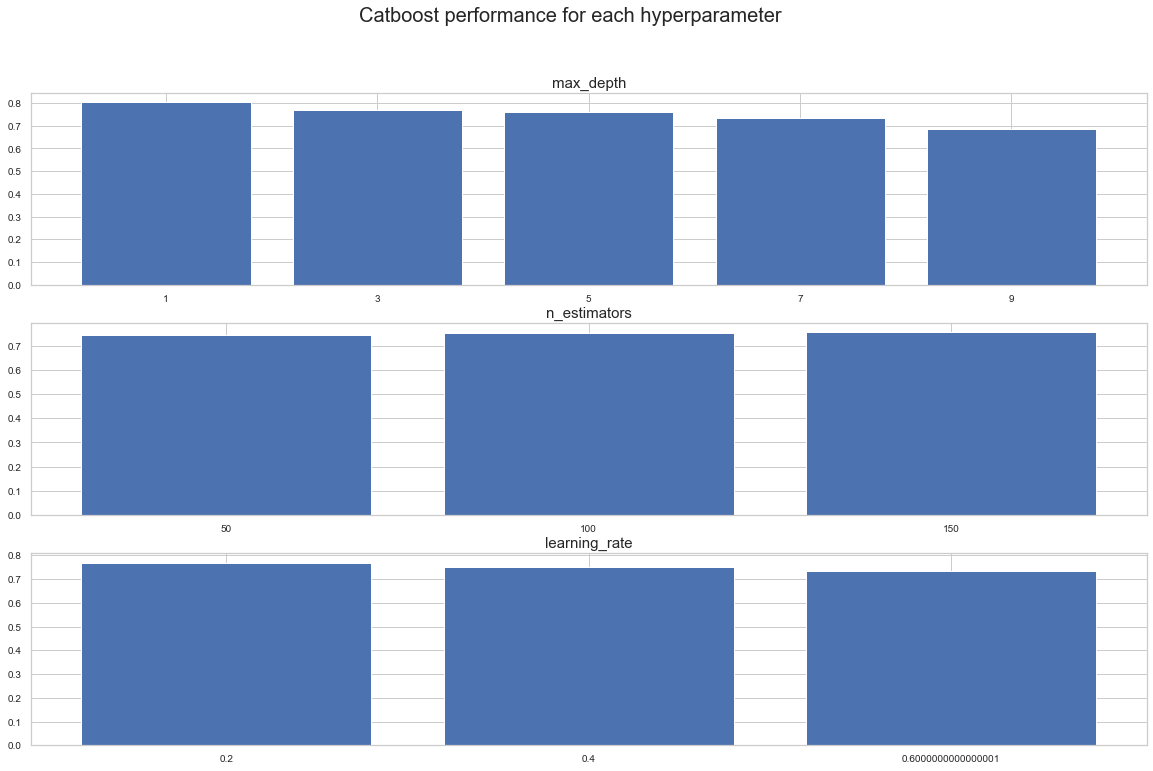

In [ ]:
model_name = 'Catboost' # GBM , AdaBoost, Light GBM, Catboost 궁금한거 로 바꿔서 실행

for_plot_values = output.loc[ output['model_name'] == model_name,:] # 예측 모델별 결과 확인을 위한 indexing

fig , axs = plt.subplots(nrows=model_params[model_name]['params'].keys().__len__(), ncols=1, figsize=(20,12)) # plot configure
fig.suptitle(f'{model_name} performance for each hyperparameter',fontsize=20) # 전체 Plot 제목

for ind , param_key in enumerate(model_params[model_name]['params'].keys()):
    
    param_for_plot = for_plot_values.groupby([f'param_{param_key}'])['mean_test_score'].mean() # 조절 하이퍼파라미터 이외에 대해서는 평균 성능 (개략적)
    
    axs[ind].bar(height = param_for_plot.values,x = [i for i in range(param_for_plot.values.shape[0])]) # bar plot 
    axs[ind].tick_params(axis='both',labelsize=10) # x,y 축 글씨 폰트 설정
    
    axs[ind].set_xticks([i for i in range(param_for_plot.values.shape[0])]) # x 축 ticks 설정
    axs[ind].set_xticklabels(param_for_plot.index.to_list()) # x 축 ticks 이름 설정

    axs[ind].set_title(f'{param_key}',fontsize=15) # 내부 plot 제목 

In [ ]:
output.reset_index(drop=True,inplace=True) # index 초기화 
plt.figure(figsize=(10,10))

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

Catboost: : 4it [08:19, 124.88s/it]
AdaBoost: 100%|█████████████████████████████████████████████████████████████████████████| 1/1 [02:41<00:00, 161.64s/it]


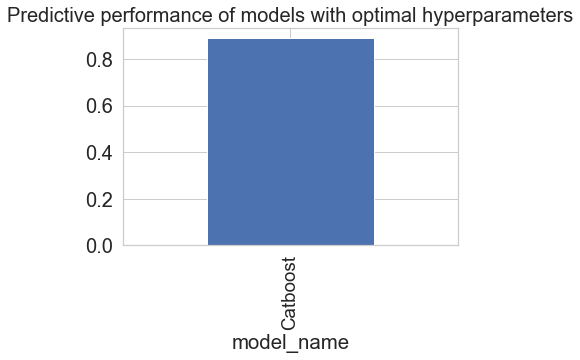

In [ ]:
idx = output.groupby(['model_name'])['mean_test_score'].idxmax() # 각 모델별 검증용 accuracy를 기준하여, Best 성능을 기록한 경우 추출
output.loc[idx,['model_name','test_r2_with_best_hyp']].set_index('model_name').plot.bar(legend=False)
plt.title('Predictive performance of models with optimal hyperparameters',fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [ ]:
output.loc[idx,['model_name','test_r2_with_best_hyp']]

,model_name,test_r2_with_best_hyp
32,Catboost,0.88959


 즉, 랜덤포레스트: 0.64, Catboost:0.88의 성능을 얻었다. 이를 통해 분류가 아닌 데이터의 값을 예측하는 상황에서는 랜덤포레스트 모델에 비해 부스팅의 경우가 더 높은 성능을 보인다는 것을 알 수 있었다.